In [151]:
import numpy as np
import pandas as pd
import cvxpy as cp
import random
from matplotlib import pyplot as plt
from pandas.io.pytables import performance_doc



class MyClassifier_25:  

    def __init__(self,dataset,class1:int,class2:int) -> None:
        self.w = None
        self.b = None
        self.w_hist = None
        self.b_hist = None
        self.classes = { 1 : class1, -1: class2, 0:None}
        self.dataset_train = dataset

        #data prep
        self.trainlabel,self.traindata = self.prepare_binary(self.dataset_train)
        self.yet_to_train_dataset = self.dataset_train
        self.sampled_dataset = None
        

        #train the classfier 
        self.i = 0 # Dataset Iterator 
        self.sel_arr = np.zeros(self.traindata.shape[0]) # Binary Array indicating whether a sample -
                     # is selected or not in order of sample selection and not dataset index
        self.mini_batch_size = 20 # Mini Batch Size for samples
        self.batch_size = 100 # Batch Size for samples
        self.perct_sel_smpls = 1 # percentage of Selected samples from dataset
        self.selection_and_train()

        
    
    def prepare_binary(self,dataset):

        #USAGE    
        # Since we have to deal with a binary classifier to diffrentiate between digits 7 and 1, 
        # we choose only those examples.
        # If asked to train a classifier on any other pair a, b (say),
        # please pass the right arguments to the following function as follows:
        # trainlabel, traindata, dataTargetDf = prepare_binary(a,b)


        # We now assign +1 to one class and -1 to the other;
        # Therefore +1 and -1 will be the new labels
        class1 = self.classes[1]
        class2 = self.classes[-1]

        trainlabel = dataset.loc[(dataset['label']== class1)  | (dataset['label']== class2) ]['label']
        trainlabel.loc[trainlabel == class1] = 1
        trainlabel.loc[trainlabel == class2] = -1
        trainlabel = trainlabel.to_numpy()
    
        #In order to match dimensions of "traindata" and "trainlabel", we convert trainlabel to two dimension array
        # for hinge loss
        trainlabel= np.reshape(trainlabel, (trainlabel.shape[0],1))   

        # We now extract the features for the two classes
        traindata = dataset.loc[(dataset['label']== class1)  | (dataset['label']== class2) ]
        traindata = traindata.drop(labels = ["label"],axis = 1)
        traindata = traindata.to_numpy()

        # print(traindata.shape[1])



        return trainlabel, traindata

    def target_df(self,traindata,trainlabel):
        # Also creating a dataframe with these, so that we can randomize the order of the train data when needed without
        # losing the mapping between feature vectors and the target labels
        trainDf=pd.DataFrame(traindata)
        targetDf=pd.DataFrame(trainlabel,columns=['target'])
        
        dataTargetDf = pd.concat([trainDf, targetDf[['target']]], axis = 1)
        ##If randomizing the order, should we use the dataframe 'finalDf'?
        return dataTargetDf

    def subset(self,dataTargetDf, subsetfrac:float):
        
        # Usage: If 20% of the data is to be randomly selected
        # subsetDf = subset(dataTargetDf, 0.2)
        
        return dataTargetDf.sample(frac = subsetfrac)
    
    def sample_selection(self,training_sample):
        
        # This method accepts only 1 random training sample at a time and decides whether to send it or not
        
        # Random Binary value is assigned initially
        accept_sample = random.randint(0, 1)
        
        # No. of mini batch and batch slots that must be filled to satisfy percentage criteria
        mini_batch_slots_to_be_filled = int(self.perct_sel_smpls * self.mini_batch_size)
        batch_slots_to_be_filled = int(self.perct_sel_smpls * self.batch_size)
        #print("mini batch slots",mini_batch_slots_to_be_filled)
        #print("batch slots",batch_slots_to_be_filled)
        # Upper bound for mini batch percentage criteria
        # if (self.i % self.mini_batch_size) >= mini_batch_slots_to_be_filled \
#         print("self.i % self.mini_batch_size",self.i % self.mini_batch_size)
        mini_start = (self.i // self.mini_batch_size)*self.mini_batch_size
        mini_end = mini_start + (self.i % self.mini_batch_size) + 1
        print("mini_start: ",mini_start,"mini_end: ", mini_end)
        print("Mini Batch: ",self.sel_arr[mini_start:mini_end])
        print("If Mini Batch Count: ",np.count_nonzero(self.sel_arr[mini_start:mini_end])," >= mini slots ",mini_batch_slots_to_be_filled," then 0")
        if np.count_nonzero(self.sel_arr[mini_start:mini_end]) >= mini_batch_slots_to_be_filled:
            accept_sample = 0
            
        # Lower bound for mini batch percentage criteria
        print("If Mini Batch iterator: ",self.i % self.mini_batch_size," >= rem mini slots ",self.mini_batch_size - mini_batch_slots_to_be_filled, \
              "and Mini Batch Count: ",np.count_nonzero(self.sel_arr[mini_start:mini_end])," < mini slots ",mini_batch_slots_to_be_filled," then 1")
        if (self.i % self.mini_batch_size) >= (self.mini_batch_size - mini_batch_slots_to_be_filled) \
        and np.count_nonzero(self.sel_arr[mini_start:mini_end]) < mini_batch_slots_to_be_filled:
            accept_sample = 1
        
        start = (self.i // self.batch_size)*self.batch_size
        end = start + (self.i % self.batch_size) + 1
        print("start: ",start,"end: ", end)
        # Upper bound for batch percentage criteria            
        # if (self.i % self.batch_size) >= batch_slots_to_be_filled \
        print("Batch: ",self.sel_arr[start:end])
        print("If Batch Count: ",np.count_nonzero(self.sel_arr[start:end])," >= slots ",batch_slots_to_be_filled, " then 0")
        if np.count_nonzero(self.sel_arr[start:end]) >= batch_slots_to_be_filled:
            accept_sample = 0
            
        # Lower bound for batch percentage criteria
        print("If Batch iterator: ",self.i % self.batch_size," >= rem slots ",self.batch_size - batch_slots_to_be_filled,\
             "and Batch Count: ",np.count_nonzero(self.sel_arr[start:end])," < slots ",batch_slots_to_be_filled, " then 1")
        if (self.i % self.batch_size) >= (self.batch_size - batch_slots_to_be_filled) \
        and np.count_nonzero(self.sel_arr[start:end]) < batch_slots_to_be_filled:
            accept_sample = 1
        
        if(self.i==0):
            accept_sample = random.randint(0, 1)
        
        print("accept_sample: ",accept_sample)
        print("~~~~~~~~~~~~~~~~~~~~~~~~")
        # Returns True if sample is accepted and False otherwise
        return True if accept_sample == 1 else False
    
    def selection_and_train(self):
        
        self.i = 0 # Dataset Iterator 
        
        # Iterate over dataset until it is exhausted
        while(self.i<self.sel_arr.size-1):
        
            # Sample and remove the sample from the dataset (to avoid duplicates in future sampling)
            sample = self.yet_to_train_dataset.sample(n=1)
            self.yet_to_train_dataset.drop(sample.index)
            
            # Perform next steps if sample selection is true
            if self.sample_selection(sample) is True:
                
                if self.sampled_dataset is None:
                    self.sampled_dataset = sample
                else:
                    self.sampled_dataset = self.sampled_dataset.append(sample, ignore_index=True)
               
                self.sel_arr[self.i] = 1
                print(self.sampled_dataset.shape)
                #print(self.sampled_dataset.tail)
            
            if (self.i % self.batch_size) == 0 and (self.i != 0):
                lbl, dt = self.prepare_binary(self.sampled_dataset)
                self.train(dt,lbl)
                self.store_w_b()
                
            self.i+=1
        
        lbl, dt = self.prepare_binary(self.sampled_dataset)
        self.train(dt,lbl)   
    
    def _hinge_loss_svm(self,traindata, trainlabel,W,w):
        m =traindata.shape[1]
        # Equation for the regularizer.
        # It is the lambda*(norm2 of W)**2
        # Here "lambda" is a non negative constant
        lambd = cp.Parameter(nonneg=True)

        ## Ideally we will have to try using different values fro "lambda"
        ## For the sake of testing the code, we have set it to 0.01
        ## Do we need to have a lambda?
        lambd = 0.01 
        reg_loss = cp.norm(W,p=2)**2
        
        #hinge loss
        hinge_loss = cp.sum(cp.pos(1-cp.multiply(trainlabel,traindata @ W - w)))
        

        
        #Objective is to minimize reg_loss and hinge_loss
        # objective_func = cp.Minimize(hinge_loss/m + lambd*reg_loss)
        prob = cp.Problem(cp.Minimize(hinge_loss/m + lambd*reg_loss))
        # Now framing the LP, along with the constraints
        return prob

    def _normal_loss_svm(self,traindata,trainlabel, W,w):
        #Constraint
        # For every feature vector traindata[i] and its corresponding label trainlabel[i]:
        # W^T*traindata[i] + w >= 1
        const = [trainlabel[i]*(traindata[i]@ W + w) >= 1 for i in range(traindata.shape[0])]
        ##Check the dimensions in the above constraint equation
        
        #Objective is to minimize reg_loss and hinge_loss
        # objective_func = cp.Minimize(hinge_loss/m + lambd*reg_loss)
        objective_func = cp.Minimize(0.5*cp.norm(W,p=2)**2)
        prob = cp.Problem(objective_func,constraints=const)
        # Now framing the LP, along with the constraints
        return prob

    def train(self,traindata,trainlabel):
        
        #USAGE
        # W, w = train(traindata, trainlabel)

        # m: Number of feature vectors
        # W and w: Weight vector and Bias value respectively
        print(traindata.shape)
        m = traindata.shape[1]
        W = cp.Variable((m,1))
        w = cp.Variable()

        
        prob = self._hinge_loss_svm(traindata,trainlabel,W,w)

        prob.solve()
        
        # Solving the problem would give us the optimal values from W and w;
        # which have to be returned, so that we can use them while testing

        ## adding to class variable
        self.w = W
        self.b = w
        

    def f(self,test_input,w=None,b=None):
        if w is None:
            w = self.w.value
        if b is None:
            b = self.b.value
        test_val = test_input.dot(w) - b
        if test_val < -1:
            test_val= -1
        elif test_val > 1:
            test_val = 1
        else:
            test_val = 0
        estimated_class = self.classes.get(test_val)
        return estimated_class
    
    def assess_classifier_performance(self,performance):
        performance = np.asarray(performance)
        correct = (np.count_nonzero(performance)/len(performance))*100
        return correct
    
    def store_w_b(self):
        # Store the w and b values each time, classifier is trained
        if self.w_hist is None:
            self.w_hist = self.w.value
            self.b_hist = np.reshape(np.array([self.b.value]),[-1,1])
            print("TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT")
            print("self.w_value:",self.w.value.shape)
            print("self.b_value:",self.b.value.shape)

        else:
            self.w_hist = np.hstack((self.w_hist,self.w.value))
            self.b_hist = np.hstack((self.b_hist,np.reshape(np.array([self.b.value]),[-1,1])))
            print("TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT")
            print("self.w_hist:",self.w_hist.shape)
            print("self.b_hist:",self.b_hist.shape)
            print("self.w_value:",self.w.value.shape)
            print("self.b_value:",self.b.value.shape)
        
        print("TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT")
        print("self.w_hist:",self.w_hist.shape)
        print("self.b_hist:",self.b_hist.shape)
        return None
            
    def random_fun(self, input_data):
        self.input_data = input_data
        print("########################################")
        
    def test(self,dataset_test,w=None,b=None):
        if w is None:
            w = self.w.value
        if b is None:
            b = self.b.value
        testlabel,testdata= self.prepare_binary(dataset_test)
        print(testlabel.shape)
        print(testdata.shape)
        print("here")
        res = []
        performance = 0
        print("3 !!!!!!!!!!!",testdata[3])
        for i in range(testdata.shape[0]):
            result = self.f(testdata[i],w,b)
            res.append(result)
            
            actual_class = self.classes.get(int(testlabel[i]))
            ## assessing performance
            if result == actual_class:#[0]:
                performance += 1
#             else:
#                 performance.append(0)
        print(performance) 
        performance /= testlabel.shape[0]
        return res, performance

    def plot_classifier_performance_vs_number_of_samples(self, dataset_test):
        
        r_hist = None
        p_hist = None
        
        for it in range(0,self.w_hist.shape[1]):
            res, performance = self.test(dataset_test,np.reshape(my_clf.w_hist[:,it],[-1,1]),np.reshape(my_clf.b_hist[:,it],[-1,1]))
            if r_hist is None and p_hist is None:
                r_hist,p_hist = res,performance
            else:
                r_hist = np.append(r_hist,res)
                p_hist = np.append(p_hist,performance)
        y = p_hist.tolist()
        x = range(0,self.batch_size*(self.sel_arr.size//self.batch_size),self.batch_size)
        plt.plot(x,y)
        

In [152]:
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

mnist_train = pd.read_csv("train.csv")
#Take copies of the master dataframes

train = mnist_train.copy()

train_7 = train.loc[train['label'] == 7]
train_1 = train.loc[train['label'] == 1]
train = train.loc[train['label'].isin([1,7])]
train_rdm = train.sample(frac = 0.5)
test_rdm = train.sample(frac = 0.2)

In [153]:
my_clf = MyClassifier_25(train,1,7)
res, performance = my_clf.test(test_rdm)

mini_start:  0 mini_end:  1
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  0 end:  1
Batch:  [0.]
If Batch Count:  0  >= slots  100  then 0
If Batch iterator:  0  >= rem slots  0 and Batch Count:  0  < slots  100  then 1
accept_sample:  0
~~~~~~~~~~~~~~~~~~~~~~~~
mini_start:  0 mini_end:  2
Mini Batch:  [0. 0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  0 end:  2
Batch:  [0. 0.]
If Batch Count:  0  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  0  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1, 785)
mini_start:  0 mini_end:  3
Mini Batch:  [0. 1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  t

If Batch iterator:  25  >= rem slots  0 and Batch Count:  24  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(25, 785)
mini_start:  20 mini_end:  27
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  0 end:  27
Batch:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  25  >= slots  100  then 0
If Batch iterator:  26  >= rem slots  0 and Batch Count:  25  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(26, 785)
mini_start:  20 mini_end:  28
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  0 end:  28
Batch:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  26  >=

mini_start:  40 mini_end:  48
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  0 end:  48
Batch:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  46  >= slots  100  then 0
If Batch iterator:  47  >= rem slots  0 and Batch Count:  46  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(47, 785)
mini_start:  40 mini_end:  49
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  0 end:  49
Batch:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  47  >= sl

mini_start:  60 mini_end:  66
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  0 end:  66
Batch:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  64  >= slots  100  then 0
If Batch iterator:  65  >= rem slots  0 and Batch Count:  64  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(65, 785)
mini_start:  60 mini_end:  67
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  0 end:  67
Batch:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

(83, 785)
mini_start:  80 mini_end:  85
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  0 end:  85
Batch:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  83  >= slots  100  then 0
If Batch iterator:  84  >= rem slots  0 and Batch Count:  83  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(84, 785)
mini_start:  80 mini_end:  86
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  0 end:  86
Batch:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 1)
self.b_hist: (1, 1)
mini_start:  100 mini_end:  102
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  100 end:  102
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(101, 785)
mini_start:  100 mini_end:  103
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  100 end:  103
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~

mini_start:  120 mini_end:  121
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  100 end:  121
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(120, 785)
mini_start:  120 mini_end:  122
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  100 end:  122
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(121, 785)
mini_start:  120 mini_end:  123
Mini Batch

If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  100 end:  140
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(139, 785)
mini_start:  140 mini_end:  141
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  100 end:  141
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slots  100  then 0
If Batch iterator:  40  >= rem slots  0 and Batch Count:  40  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~

mini_start:  160 mini_end:  161
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  100 end:  161
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  60  >= slots  100  then 0
If Batch iterator:  60  >= rem slots  0 and Batch Count:  60  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(160, 785)
mini_start:  160 mini_end:  162
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  100 end:  162
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 

mini_start:  160 mini_end:  180
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  100 end:  180
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  79  >= slots  100  then 0
If Batch iterator:  79  >= rem slots  0 and Batch Count:  79  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(179, 785)
mini_start:  180 mini_end:  181
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  100 end:  181
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  180 mini_end:  199
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  100 end:  199
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  98  >= slots  100  then 0
If Batch iterator:  98  >= rem slots  0 and Batch Count:  98  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(198, 785)
mini_start:  180 mini_end:  200
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count

If Batch iterator:  29  >= rem slots  0 and Batch Count:  29  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(229, 785)
mini_start:  220 mini_end:  231
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  200 end:  231
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  30  >= slots  100  then 0
If Batch iterator:  30  >= rem slots  0 and Batch Count:  30  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(230, 785)
mini_start:  220 mini_end:  232
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  200 end:  232
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  240 mini_end:  253
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  200 end:  253
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  52  >= slots  100  then 0
If Batch iterator:  52  >= rem slots  0 and Batch Count:  52  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(252, 785)
mini_start:  240 mini_end:  254
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  200 end:  254
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  260 mini_end:  271
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  200 end:  271
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  70  >= slots  100  then 0
If Batch iterator:  70  >= rem slots  0 and Batch Count:  70  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(270, 785)
mini_start:  260 mini_end:  272
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  200 end:  272
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  280 mini_end:  290
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  200 end:  290
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  89  >= slots  100  then 0
If Batch iterator:  89  >= rem slots  0 and Batch Count:  89  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(289, 785)
mini_start:  280 mini_end:  291
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  200 end:  291
Batch:  [1. 1. 1. 1. 1. 1. 1. 1

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 3)
self.b_hist: (1, 3)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 3)
self.b_hist: (1, 3)
mini_start:  300 mini_end:  302
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  300 end:  302
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(301, 785)
mini_start:  300 mini_end:  303
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  300 end:  303
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < slots  100  the

(320, 785)
mini_start:  320 mini_end:  322
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  300 end:  322
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(321, 785)
mini_start:  320 mini_end:  323
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  300 end:  323
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(322, 785)
mini_start:  320 mi

accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(342, 785)
mini_start:  340 mini_end:  344
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  300 end:  344
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  43  >= slots  100  then 0
If Batch iterator:  43  >= rem slots  0 and Batch Count:  43  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(343, 785)
mini_start:  340 mini_end:  345
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  300 end:  345
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch C

mini_start:  360 mini_end:  366
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  300 end:  366
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  65  >= slots  100  then 0
If Batch iterator:  65  >= rem slots  0 and Batch Count:  65  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(365, 785)
mini_start:  360 mini_end:  367
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  300 end:  367
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  380 mini_end:  384
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  300 end:  384
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  83  >= slots  100  then 0
If Batch iterator:  83  >= rem slots  0 and Batch Count:  83  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(383, 785)
mini_start:  380 mini_end:  385
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  300 end:  385
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 4)
self.b_hist: (1, 4)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 4)
self.b_hist: (1, 4)
mini_start:  400 mini_end:  402
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  400 end:  402
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(401, 785)
mini_start:  400 mini_end:  403
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  400 end:  403
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < slots  100  the

Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  400 end:  423
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(422, 785)
mini_start:  420 mini_end:  424
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  400 end:  424
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  23  >= slots  100  then 0
If Batch iterator:  23  >= rem slots  0 and Batch Count:  23  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(423, 785)
mini_start:  420 mini_end:  425
Mini Batch:  [1. 1

If Batch iterator:  44  >= rem slots  0 and Batch Count:  44  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(444, 785)
mini_start:  440 mini_end:  446
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  400 end:  446
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  45  >= slots  100  then 0
If Batch iterator:  45  >= rem slots  0 and Batch Count:  45  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(445, 785)
mini_start:  440 mini_end:  447
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  400 end:  447
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  460 mini_end:  468
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  400 end:  468
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  67  >= slots  100  then 0
If Batch iterator:  67  >= rem slots  0 and Batch Count:  67  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(467, 785)
mini_start:  460 mini_end:  469
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  400 end:  469
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  480 mini_end:  486
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  400 end:  486
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  85  >= slots  100  then 0
If Batch iterator:  85  >= rem slots  0 and Batch Count:  85  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(485, 785)
mini_start:  480 mini_end:  487
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  400 end:  487
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 5)
self.b_hist: (1, 5)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 5)
self.b_hist: (1, 5)
mini_start:  500 mini_end:  502
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  500 end:  502
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(501, 785)
mini_start:  500 mini_end:  503
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  500 end:  503
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < slots  100  the

(523, 785)
mini_start:  520 mini_end:  525
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  500 end:  525
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  24  >= slots  100  then 0
If Batch iterator:  24  >= rem slots  0 and Batch Count:  24  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(524, 785)
mini_start:  520 mini_end:  526
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  500 end:  526
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  25  >= slots  100  then 0
If Batch iterator:  25  >= rem slots  0 and Batch Count:  25  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~

mini_start:  540 mini_end:  547
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  500 end:  547
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  46  >= slots  100  then 0
If Batch iterator:  46  >= rem slots  0 and Batch Count:  46  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(546, 785)
mini_start:  540 mini_end:  548
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  500 end:  548
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  47  >= slot

mini_start:  560 mini_end:  565
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  500 end:  565
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  64  >= slots  100  then 0
If Batch iterator:  64  >= rem slots  0 and Batch Count:  64  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(564, 785)
mini_start:  560 mini_end:  566
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  500 end:  566
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  580 mini_end:  583
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  500 end:  583
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  82  >= slots  100  then 0
If Batch iterator:  82  >= rem slots  0 and Batch Count:  82  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(582, 785)
mini_start:  580 mini_end:  584
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  500 end:  584
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 6)
self.b_hist: (1, 6)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 6)
self.b_hist: (1, 6)
mini_start:  600 mini_end:  602
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  600 end:  602
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(601, 785)
mini_start:  600 mini_end:  603
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  600 end:  603
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < slots  100  the

mini_start:  620 mini_end:  626
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  600 end:  626
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  25  >= slots  100  then 0
If Batch iterator:  25  >= rem slots  0 and Batch Count:  25  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(625, 785)
mini_start:  620 mini_end:  627
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  600 end:  627
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  26  >= slots  100  then 0
If Batch iterator:  26  >= rem slots  0 and Batch Count:  26  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~

mini_start:  640 mini_end:  643
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  600 end:  643
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  42  >= slots  100  then 0
If Batch iterator:  42  >= rem slots  0 and Batch Count:  42  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(642, 785)
mini_start:  640 mini_end:  644
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  600 end:  644
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  43  >= slots  100  then 0
If Batch iterator:  43  >= rem sl

mini_start:  660 mini_end:  661
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  600 end:  661
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  60  >= slots  100  then 0
If Batch iterator:  60  >= rem slots  0 and Batch Count:  60  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(660, 785)
mini_start:  660 mini_end:  662
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  600 end:  662
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 

mini_start:  680 mini_end:  683
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  600 end:  683
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  82  >= slots  100  then 0
If Batch iterator:  82  >= rem slots  0 and Batch Count:  82  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(682, 785)
mini_start:  680 mini_end:  684
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  600 end:  684
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 

mini_start:  700 mini_end:  701
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  700 end:  701
Batch:  [0.]
If Batch Count:  0  >= slots  100  then 0
If Batch iterator:  0  >= rem slots  0 and Batch Count:  0  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(700, 785)
(700, 784)
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 7)
self.b_hist: (1, 7)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 7)
self.b_hist: (1, 7)
mini_start:  700 mini_end:  702
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  700 end:  702
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then

mini_start:  720 mini_end:  724
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  700 end:  724
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  23  >= slots  100  then 0
If Batch iterator:  23  >= rem slots  0 and Batch Count:  23  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(723, 785)
mini_start:  720 mini_end:  725
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  700 end:  725
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  24  >= slots  100  then 0
If Batch iterator:  24  >= rem slots  0 and Batch Count:  24  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(724, 785)
mini_

(740, 785)
mini_start:  740 mini_end:  742
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  700 end:  742
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  41  >= slots  100  then 0
If Batch iterator:  41  >= rem slots  0 and Batch Count:  41  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(741, 785)
mini_start:  740 mini_end:  743
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  700 end:  743
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  42  >= slots  100  then 0
If Batch iterator:  42  >= rem slo

If Batch iterator:  61  >= rem slots  0 and Batch Count:  61  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(761, 785)
mini_start:  760 mini_end:  763
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  700 end:  763
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  62  >= slots  100  then 0
If Batch iterator:  62  >= rem slots  0 and Batch Count:  62  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(762, 785)
mini_start:  760 mini_end:  764
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  700 end:  764
Batch:  [1. 1. 1. 1. 

mini_start:  780 mini_end:  781
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  700 end:  781
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  80  >= slots  100  then 0
If Batch iterator:  80  >= rem slots  0 and Batch Count:  80  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(780, 785)
mini_start:  780 mini_end:  782
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  700 end:  782
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

mini_start:  780 mini_end:  797
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  700 end:  797
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  96  >= slots  100  then 0
If Batch iterator:  96  >= rem slots  0 and Batch Count:  96  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(796, 785)
mini_start:  780 mini_end:  798
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slot

mini_start:  820 mini_end:  823
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  800 end:  823
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(822, 785)
mini_start:  820 mini_end:  824
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  800 end:  824
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  23  >= slots  100  then 0
If Batch iterator:  23  >= rem slots  0 and Batch Count:  23  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(823, 785)
mini_start:  820 m

accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(840, 785)
mini_start:  840 mini_end:  842
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  800 end:  842
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  41  >= slots  100  then 0
If Batch iterator:  41  >= rem slots  0 and Batch Count:  41  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(841, 785)
mini_start:  840 mini_end:  843
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  800 end:  843
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  42  >= slots  100

mini_start:  860 mini_end:  863
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  800 end:  863
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  62  >= slots  100  then 0
If Batch iterator:  62  >= rem slots  0 and Batch Count:  62  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(862, 785)
mini_start:  860 mini_end:  864
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  800 end:  864
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 

mini_start:  880 mini_end:  881
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  800 end:  881
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  80  >= slots  100  then 0
If Batch iterator:  80  >= rem slots  0 and Batch Count:  80  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(880, 785)
mini_start:  880 mini_end:  882
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  800 end:  882
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

mini_start:  880 mini_end:  899
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  800 end:  899
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  98  >= slots  100  then 0
If Batch iterator:  98  >= rem slots  0 and Batch Count:  98  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(898, 785)
mini_start:  880 mini_end:  900
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count

mini_start:  920 mini_end:  921
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  900 end:  921
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(920, 785)
mini_start:  920 mini_end:  922
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  900 end:  922
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(921, 785)
mini_start:  920 mini_end:  923
Mini Batch

mini_start:  940 mini_end:  943
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  900 end:  943
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  42  >= slots  100  then 0
If Batch iterator:  42  >= rem slots  0 and Batch Count:  42  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(942, 785)
mini_start:  940 mini_end:  944
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  900 end:  944
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  43  >= slots  100  then 0
If Batch iterator:  43  >= rem sl

(959, 785)
mini_start:  960 mini_end:  961
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  900 end:  961
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  60  >= slots  100  then 0
If Batch iterator:  60  >= rem slots  0 and Batch Count:  60  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(960, 785)
mini_start:  960 mini_end:  962
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  900 end:  962
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1

mini_start:  960 mini_end:  978
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  900 end:  978
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  77  >= slots  100  then 0
If Batch iterator:  77  >= rem slots  0 and Batch Count:  77  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(977, 785)
mini_start:  960 mini_end:  979
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  900 end:  979
Batch:  [1. 1. 1

(998, 785)
mini_start:  980 mini_end:  1000
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  900 end:  1000
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  99  >= slots  100  then 0
If Batch iterator:  99  >= rem slots  0 and Batch Count:  99  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(999, 785)
mini_start:  1000 mini_end:  1001
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start: 

mini_start:  1020 mini_end:  1022
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  1000 end:  1022
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1021, 785)
mini_start:  1020 mini_end:  1023
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  1000 end:  1023
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1022, 785)
mini_start:  1020 mi

mini_start:  1020 mini_end:  1040
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  1000 end:  1040
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1039, 785)
mini_start:  1040 mini_end:  1041
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  1000 end:  1041
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slots  100  then

mini_start:  1040 mini_end:  1057
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  1000 end:  1057
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1056, 785)
mini_start:  1040 mini_end:  1058
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  1000 end:  1058
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  1060 mini_end:  1077
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  1000 end:  1077
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  76  >= slots  100  then 0
If Batch iterator:  76  >= rem slots  0 and Batch Count:  76  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1076, 785)
mini_start:  1060 mini_end:  1078
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  1000 end:  1078
Batch:  [1. 1. 1

(1094, 785)
mini_start:  1080 mini_end:  1096
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  1000 end:  1096
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  95  >= slots  100  then 0
If Batch iterator:  95  >= rem slots  0 and Batch Count:  95  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1095, 785)
mini_start:  1080 mini_end:  1097
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < 

If Batch iterator:  23  >= rem slots  0 and Batch Count:  23  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1123, 785)
mini_start:  1120 mini_end:  1125
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  1100 end:  1125
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  24  >= slots  100  then 0
If Batch iterator:  24  >= rem slots  0 and Batch Count:  24  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1124, 785)
mini_start:  1120 mini_end:  1126
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  1100 end:  1126
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  25  >= s

mini_start:  1140 mini_end:  1146
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  1100 end:  1146
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  45  >= slots  100  then 0
If Batch iterator:  45  >= rem slots  0 and Batch Count:  45  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1145, 785)
mini_start:  1140 mini_end:  1147
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  1100 end:  1147
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  46  >= slots  

mini_start:  1160 mini_end:  1162
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  1100 end:  1162
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  61  >= slots  100  then 0
If Batch iterator:  61  >= rem slots  0 and Batch Count:  61  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1161, 785)
mini_start:  1160 mini_end:  1163
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  1100 end:  1163
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 

If Batch Count:  80  >= slots  100  then 0
If Batch iterator:  80  >= rem slots  0 and Batch Count:  80  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1180, 785)
mini_start:  1180 mini_end:  1182
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  1100 end:  1182
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  81  >= slots  100  then 0
If Batch iterator:  81  >= rem slots  0 and Batch Count:  81  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1181, 785)
mini_start:  1180 mini_end:  1183
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini 

(1200, 784)
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 12)
self.b_hist: (1, 12)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 12)
self.b_hist: (1, 12)
mini_start:  1200 mini_end:  1202
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  1200 end:  1202
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1201, 785)
mini_start:  1200 mini_end:  1203
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  1200 end:  1203
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Cou

mini_start:  1220 mini_end:  1224
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  1200 end:  1224
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  23  >= slots  100  then 0
If Batch iterator:  23  >= rem slots  0 and Batch Count:  23  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1223, 785)
mini_start:  1220 mini_end:  1225
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  1200 end:  1225
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  24  >= slots  100  then 0
If Batch iterator:  24  >= rem slots  0 and Batch Count:  24  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1224, 

(1244, 785)
mini_start:  1240 mini_end:  1246
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  1200 end:  1246
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  45  >= slots  100  then 0
If Batch iterator:  45  >= rem slots  0 and Batch Count:  45  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1245, 785)
mini_start:  1240 mini_end:  1247
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  1200 end:  1247
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  46

mini_start:  1260 mini_end:  1266
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  1200 end:  1266
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  65  >= slots  100  then 0
If Batch iterator:  65  >= rem slots  0 and Batch Count:  65  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1265, 785)
mini_start:  1260 mini_end:  1267
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  1200 end:  1267
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  1200 end:  1283
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  82  >= slots  100  then 0
If Batch iterator:  82  >= rem slots  0 and Batch Count:  82  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1282, 785)
mini_start:  1280 mini_end:  1284
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  1200 end:  1284
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

mini_start:  1280 mini_end:  1297
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  1200 end:  1297
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  96  >= slots  100  then 0
If Batch iterator:  96  >= rem slots  0 and Batch Count:  96  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1296, 785)
mini_start:  1280 mini_end:  1298
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mi

mini_start:  1320 mini_end:  1323
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  1300 end:  1323
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1322, 785)
mini_start:  1320 mini_end:  1324
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  1300 end:  1324
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  23  >= slots  100  then 0
If Batch iterator:  23  >= rem slots  0 and Batch Count:  23  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1323, 785)
mini_sta

If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1338, 785)
mini_start:  1320 mini_end:  1340
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  1300 end:  1340
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1339, 785)
mini_start:  1340 mini_end:  1341
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  1300 end:  1341
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 

(1357, 785)
mini_start:  1340 mini_end:  1359
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  1300 end:  1359
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  58  >= slots  100  then 0
If Batch iterator:  58  >= rem slots  0 and Batch Count:  58  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1358, 785)
mini_start:  1340 mini_end:  1360
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  1300 end:  1360
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(1374, 785)
mini_start:  1360 mini_end:  1376
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  1300 end:  1376
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1375, 785)
mini_start:  1360 mini_end:  1377
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  1300 end:  1377
Batch:  [1. 1

mini_start:  1380 mini_end:  1393
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  1300 end:  1393
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  92  >= slots  100  then 0
If Batch iterator:  92  >= rem slots  0 and Batch Count:  92  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1392, 785)
mini_start:  1380 mini_end:  1394
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  1300 end

(1420, 785)
mini_start:  1420 mini_end:  1422
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  1400 end:  1422
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1421, 785)
mini_start:  1420 mini_end:  1423
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  1400 end:  1423
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1422, 785)
mini_sta

(1438, 785)
mini_start:  1420 mini_end:  1440
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  1400 end:  1440
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1439, 785)
mini_start:  1440 mini_end:  1441
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  1400 end:  1441
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slot

(1455, 785)
mini_start:  1440 mini_end:  1457
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  1400 end:  1457
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1456, 785)
mini_start:  1440 mini_end:  1458
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  1400 end:  1458
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1474, 785)
mini_start:  1460 mini_end:  1476
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  1400 end:  1476
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1475, 785)
mini_start:  1460 mini_end:  1477
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch

mini_start:  1480 mini_end:  1492
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  1400 end:  1492
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1491, 785)
mini_start:  1480 mini_end:  1493
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  1400 end:  1493
B

If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1519, 785)
mini_start:  1520 mini_end:  1521
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  1500 end:  1521
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1520, 785)
mini_start:  1520 mini_end:  1522
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  1500 end:  1522
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem s

mini_start:  1520 mini_end:  1539
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  1500 end:  1539
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1538, 785)
mini_start:  1520 mini_end:  1540
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  1500 end:  1540
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  1540 mini_end:  1556
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  1500 end:  1556
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  55  >= slots  100  then 0
If Batch iterator:  55  >= rem slots  0 and Batch Count:  55  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1555, 785)
mini_start:  1540 mini_end:  1557
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  1500 end:  1557
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1

(1572, 785)
mini_start:  1560 mini_end:  1574
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  1500 end:  1574
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  73  >= slots  100  then 0
If Batch iterator:  73  >= rem slots  0 and Batch Count:  73  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1573, 785)
mini_start:  1560 mini_end:  1575
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  1500 end:  1575
Batch:  [1. 1. 1. 1. 1. 1. 1. 1

(1590, 785)
mini_start:  1580 mini_end:  1592
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  1500 end:  1592
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1591, 785)
mini_start:  1580 mini_end:  1593
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  1500 

mini_start:  1620 mini_end:  1621
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  1600 end:  1621
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1620, 785)
mini_start:  1620 mini_end:  1622
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  1600 end:  1622
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1621, 785)
mini_start:  1620 mini_end:  162

mini_start:  1620 mini_end:  1639
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  1600 end:  1639
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1638, 785)
mini_start:  1620 mini_end:  1640
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  1600 end:  1640
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

If Batch iterator:  55  >= rem slots  0 and Batch Count:  55  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1655, 785)
mini_start:  1640 mini_end:  1657
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  1600 end:  1657
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1656, 785)
mini_start:  1640 mini_end:  1658
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch 

mini_start:  1660 mini_end:  1675
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  1600 end:  1675
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1674, 785)
mini_start:  1660 mini_end:  1676
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  1600 end:  1676
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  1680 mini_end:  1693
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  1600 end:  1693
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  92  >= slots  100  then 0
If Batch iterator:  92  >= rem slots  0 and Batch Count:  92  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1692, 785)
mini_start:  1680 mini_end:  1694
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  1600 end

(1719, 785)
mini_start:  1720 mini_end:  1721
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  1700 end:  1721
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1720, 785)
mini_start:  1720 mini_end:  1722
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  1700 end:  1722
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1721, 785)
mini_start:  1720 mi

mini_start:  1720 mini_end:  1738
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  1700 end:  1738
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1737, 785)
mini_start:  1720 mini_end:  1739
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  1700 end:  1739
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
I

mini_start:  1740 mini_end:  1757
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  1700 end:  1757
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1756, 785)
mini_start:  1740 mini_end:  1758
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  1700 end:  1758
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  1760 mini_end:  1775
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  1700 end:  1775
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1774, 785)
mini_start:  1760 mini_end:  1776
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  1700 end:  1776
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  1780 mini_end:  1793
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  1700 end:  1793
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  92  >= slots  100  then 0
If Batch iterator:  92  >= rem slots  0 and Batch Count:  92  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1792, 785)
mini_start:  1780 mini_end:  1794
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  1700 end

mini_start:  1800 mini_end:  1820
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  1800 end:  1820
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1819, 785)
mini_start:  1820 mini_end:  1821
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  1800 end:  1821
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~

mini_start:  1820 mini_end:  1838
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  1800 end:  1838
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1837, 785)
mini_start:  1820 mini_end:  1839
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  1800 end:  1839
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
I

(1851, 785)
mini_start:  1840 mini_end:  1853
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  1800 end:  1853
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  52  >= slots  100  then 0
If Batch iterator:  52  >= rem slots  0 and Batch Count:  52  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1852, 785)
mini_start:  1840 mini_end:  1854
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  1800 end:  1854
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1

If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  1800 end:  1867
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  66  >= slots  100  then 0
If Batch iterator:  66  >= rem slots  0 and Batch Count:  66  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1866, 785)
mini_start:  1860 mini_end:  1868
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  1800 end:  1868
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  1880 mini_end:  1883
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  1800 end:  1883
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  82  >= slots  100  then 0
If Batch iterator:  82  >= rem slots  0 and Batch Count:  82  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1882, 785)
mini_start:  1880 mini_end:  1884
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  1800 end:  1884
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 

mini_start:  1880 mini_end:  1899
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  1800 end:  1899
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  98  >= slots  100  then 0
If Batch iterator:  98  >= rem slots  0 and Batch Count:  98  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1898, 785)
mini_start:  1880 mini_end:  1900
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batc

(1919, 785)
mini_start:  1920 mini_end:  1921
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  1900 end:  1921
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1920, 785)
mini_start:  1920 mini_end:  1922
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  1900 end:  1922
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1921, 785)
mini_start:  1920 mi

(1937, 785)
mini_start:  1920 mini_end:  1939
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  1900 end:  1939
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1938, 785)
mini_start:  1920 mini_end:  1940
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  1900 end:  1940
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.

(1955, 785)
mini_start:  1940 mini_end:  1957
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  1900 end:  1957
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1956, 785)
mini_start:  1940 mini_end:  1958
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  1900 end:  1958
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  1960 mini_end:  1974
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  1900 end:  1974
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  73  >= slots  100  then 0
If Batch iterator:  73  >= rem slots  0 and Batch Count:  73  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1973, 785)
mini_start:  1960 mini_end:  1975
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  1900 end:  1975
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(1990, 785)
mini_start:  1980 mini_end:  1992
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  1900 end:  1992
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(1991, 785)
mini_start:  1980 mini_end:  1993
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  1900 

mini_start:  2000 mini_end:  2019
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2000 end:  2019
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2018, 785)
mini_start:  2000 mini_end:  2020
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  2000 end:  2020
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slot

(2036, 785)
mini_start:  2020 mini_end:  2038
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  2000 end:  2038
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2037, 785)
mini_start:  2020 mini_end:  2039
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2000 end:  2039
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(2054, 785)
mini_start:  2040 mini_end:  2056
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  2000 end:  2056
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  55  >= slots  100  then 0
If Batch iterator:  55  >= rem slots  0 and Batch Count:  55  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2055, 785)
mini_start:  2040 mini_end:  2057
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  2000 end:  2057
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  2060 mini_end:  2072
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  2000 end:  2072
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  71  >= slots  100  then 0
If Batch iterator:  71  >= rem slots  0 and Batch Count:  71  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2071, 785)
mini_start:  2060 mini_end:  2073
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  2000 end:  2073
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(2088, 785)
mini_start:  2080 mini_end:  2090
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  2000 end:  2090
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  89  >= slots  100  then 0
If Batch iterator:  89  >= rem slots  0 and Batch Count:  89  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2089, 785)
mini_start:  2080 mini_end:  2091
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  2000 end:  2091
Batch:  [1

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 21)
self.b_hist: (1, 21)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 21)
self.b_hist: (1, 21)
mini_start:  2100 mini_end:  2102
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  2100 end:  2102
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2101, 785)
mini_start:  2100 mini_end:  2103
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  2100 end:  2103
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < sl

(2117, 785)
mini_start:  2100 mini_end:  2119
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2100 end:  2119
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2118, 785)
mini_start:  2100 mini_end:  2120
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  2100 end:  2120
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:

(2136, 785)
mini_start:  2120 mini_end:  2138
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  2100 end:  2138
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2137, 785)
mini_start:  2120 mini_end:  2139
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2100 end:  2139
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  2140 mini_end:  2155
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  2100 end:  2155
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  54  >= slots  100  then 0
If Batch iterator:  54  >= rem slots  0 and Batch Count:  54  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2154, 785)
mini_start:  2140 mini_end:  2156
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  2100 end:  2156
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1

(2171, 785)
mini_start:  2160 mini_end:  2173
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  2100 end:  2173
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  72  >= slots  100  then 0
If Batch iterator:  72  >= rem slots  0 and Batch Count:  72  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2172, 785)
mini_start:  2160 mini_end:  2174
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  2100 end:  2174
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(2188, 785)
mini_start:  2180 mini_end:  2190
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  2100 end:  2190
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  89  >= slots  100  then 0
If Batch iterator:  89  >= rem slots  0 and Batch Count:  89  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2189, 785)
mini_start:  2180 mini_end:  2191
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  2100 end:  2191
Batch:  [1

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 22)
self.b_hist: (1, 22)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 22)
self.b_hist: (1, 22)
mini_start:  2200 mini_end:  2202
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  2200 end:  2202
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2201, 785)
mini_start:  2200 mini_end:  2203
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  2200 end:  2203
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < sl

mini_start:  2200 mini_end:  2219
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2200 end:  2219
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2218, 785)
mini_start:  2200 mini_end:  2220
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  2200 end:  2220
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slot

(2236, 785)
mini_start:  2220 mini_end:  2238
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  2200 end:  2238
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2237, 785)
mini_start:  2220 mini_end:  2239
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2200 end:  2239
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  2240 mini_end:  2255
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  2200 end:  2255
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  54  >= slots  100  then 0
If Batch iterator:  54  >= rem slots  0 and Batch Count:  54  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2254, 785)
mini_start:  2240 mini_end:  2256
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  2200 end:  2256
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1

mini_start:  2260 mini_end:  2272
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  2200 end:  2272
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  71  >= slots  100  then 0
If Batch iterator:  71  >= rem slots  0 and Batch Count:  71  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2271, 785)
mini_start:  2260 mini_end:  2273
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  2200 end:  2273
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  2280 mini_end:  2289
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  2200 end:  2289
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  88  >= slots  100  then 0
If Batch iterator:  88  >= rem slots  0 and Batch Count:  88  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2288, 785)
mini_start:  2280 mini_end:  2290
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  2200 end:  2290
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 23)
self.b_hist: (1, 23)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 23)
self.b_hist: (1, 23)
mini_start:  2300 mini_end:  2302
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  2300 end:  2302
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2301, 785)
mini_start:  2300 mini_end:  2303
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  2300 end:  2303
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < sl

(2317, 785)
mini_start:  2300 mini_end:  2319
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2300 end:  2319
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2318, 785)
mini_start:  2300 mini_end:  2320
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  2300 end:  2320
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:

mini_start:  2320 mini_end:  2336
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  2300 end:  2336
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= slots  100  then 0
If Batch iterator:  35  >= rem slots  0 and Batch Count:  35  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2335, 785)
mini_start:  2320 mini_end:  2337
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  2300 end:  2337
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  36  >= s

(2352, 785)
mini_start:  2340 mini_end:  2354
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  2300 end:  2354
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  53  >= slots  100  then 0
If Batch iterator:  53  >= rem slots  0 and Batch Count:  53  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2353, 785)
mini_start:  2340 mini_end:  2355
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  2300 end:  2355
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1

(2369, 785)
mini_start:  2360 mini_end:  2371
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  2300 end:  2371
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  70  >= slots  100  then 0
If Batch iterator:  70  >= rem slots  0 and Batch Count:  70  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2370, 785)
mini_start:  2360 mini_end:  2372
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  2300 end:  2372
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  2380 mini_end:  2388
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  2300 end:  2388
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  87  >= slots  100  then 0
If Batch iterator:  87  >= rem slots  0 and Batch Count:  87  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2387, 785)
mini_start:  2380 mini_end:  2389
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  2300 end:  2389
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 24)
self.b_hist: (1, 24)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 24)
self.b_hist: (1, 24)
mini_start:  2400 mini_end:  2402
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  2400 end:  2402
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2401, 785)
mini_start:  2400 mini_end:  2403
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  2400 end:  2403
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < sl

mini_start:  2420 mini_end:  2436
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  2400 end:  2436
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= slots  100  then 0
If Batch iterator:  35  >= rem slots  0 and Batch Count:  35  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2435, 785)
mini_start:  2420 mini_end:  2437
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  2400 end:  2437
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  36  >= s

(2451, 785)
mini_start:  2440 mini_end:  2453
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  2400 end:  2453
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  52  >= slots  100  then 0
If Batch iterator:  52  >= rem slots  0 and Batch Count:  52  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2452, 785)
mini_start:  2440 mini_end:  2454
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  2400 end:  2454
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1

(2467, 785)
mini_start:  2460 mini_end:  2469
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  2400 end:  2469
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  68  >= slots  100  then 0
If Batch iterator:  68  >= rem slots  0 and Batch Count:  68  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2468, 785)
mini_start:  2460 mini_end:  2470
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  2400 end:  2470
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1

mini_start:  2480 mini_end:  2485
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  2400 end:  2485
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  84  >= slots  100  then 0
If Batch iterator:  84  >= rem slots  0 and Batch Count:  84  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2484, 785)
mini_start:  2480 mini_end:  2486
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  2400 end:  2486
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(2496, 785)
mini_start:  2480 mini_end:  2498
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  2400 end:  2498
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  97  >= slots  100  then 0
If Batch iterator:  97  >= rem slots  0 and Batch Count:  97  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2497, 785)
mini_start:  2480 mini_end:  2499
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini B

(2516, 785)
mini_start:  2500 mini_end:  2518
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  2500 end:  2518
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  17  >= slots  100  then 0
If Batch iterator:  17  >= rem slots  0 and Batch Count:  17  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2517, 785)
mini_start:  2500 mini_end:  2519
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2500 end:  2519
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slot

(2533, 785)
mini_start:  2520 mini_end:  2535
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  2500 end:  2535
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  34  >= slots  100  then 0
If Batch iterator:  34  >= rem slots  0 and Batch Count:  34  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2534, 785)
mini_start:  2520 mini_end:  2536
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  2500 end:  2536
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= s

(2548, 785)
mini_start:  2540 mini_end:  2550
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  2500 end:  2550
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  49  >= slots  100  then 0
If Batch iterator:  49  >= rem slots  0 and Batch Count:  49  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2549, 785)
mini_start:  2540 mini_end:  2551
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  2500 end:  2551
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(2563, 785)
mini_start:  2560 mini_end:  2565
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  2500 end:  2565
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  64  >= slots  100  then 0
If Batch iterator:  64  >= rem slots  0 and Batch Count:  64  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2564, 785)
mini_start:  2560 mini_end:  2566
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  2500 end:  2566
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(2579, 785)
mini_start:  2580 mini_end:  2581
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  2500 end:  2581
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  80  >= slots  100  then 0
If Batch iterator:  80  >= rem slots  0 and Batch Count:  80  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2580, 785)
mini_start:  2580 mini_end:  2582
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  2500 end:  2582
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 

(2594, 785)
mini_start:  2580 mini_end:  2596
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  2500 end:  2596
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  95  >= slots  100  then 0
If Batch iterator:  95  >= rem slots  0 and Batch Count:  95  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2595, 785)
mini_start:  2580 mini_end:  2597
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < 

mini_start:  2600 mini_end:  2618
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  2600 end:  2618
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  17  >= slots  100  then 0
If Batch iterator:  17  >= rem slots  0 and Batch Count:  17  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2617, 785)
mini_start:  2600 mini_end:  2619
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2600 end:  2619
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then

(2633, 785)
mini_start:  2620 mini_end:  2635
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  2600 end:  2635
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  34  >= slots  100  then 0
If Batch iterator:  34  >= rem slots  0 and Batch Count:  34  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2634, 785)
mini_start:  2620 mini_end:  2636
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  2600 end:  2636
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= s

mini_start:  2640 mini_end:  2650
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  2600 end:  2650
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  49  >= slots  100  then 0
If Batch iterator:  49  >= rem slots  0 and Batch Count:  49  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2649, 785)
mini_start:  2640 mini_end:  2651
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  2600 end:  2651
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  2660 mini_end:  2666
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  2600 end:  2666
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  65  >= slots  100  then 0
If Batch iterator:  65  >= rem slots  0 and Batch Count:  65  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2665, 785)
mini_start:  2660 mini_end:  2667
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  2600 end:  2667
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  2680 mini_end:  2682
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  2600 end:  2682
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  81  >= slots  100  then 0
If Batch iterator:  81  >= rem slots  0 and Batch Count:  81  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2681, 785)
mini_start:  2680 mini_end:  2683
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  2600 end:  2683
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 

mini_start:  2680 mini_end:  2698
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  2600 end:  2698
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  97  >= slots  100  then 0
If Batch iterator:  97  >= rem slots  0 and Batch Count:  97  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2697, 785)
mini_start:  2680 mini_end:  2699
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count: 

(2716, 785)
mini_start:  2700 mini_end:  2718
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  2700 end:  2718
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  17  >= slots  100  then 0
If Batch iterator:  17  >= rem slots  0 and Batch Count:  17  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2717, 785)
mini_start:  2700 mini_end:  2719
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2700 end:  2719
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slot

mini_start:  2720 mini_end:  2734
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  2700 end:  2734
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  33  >= slots  100  then 0
If Batch iterator:  33  >= rem slots  0 and Batch Count:  33  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2733, 785)
mini_start:  2720 mini_end:  2735
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  2700 end:  2735
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  34  >= slots  100  then 0
If Bat

mini_start:  2740 mini_end:  2750
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  2700 end:  2750
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  49  >= slots  100  then 0
If Batch iterator:  49  >= rem slots  0 and Batch Count:  49  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2749, 785)
mini_start:  2740 mini_end:  2751
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  2700 end:  2751
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  2760 mini_end:  2766
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  2700 end:  2766
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  65  >= slots  100  then 0
If Batch iterator:  65  >= rem slots  0 and Batch Count:  65  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2765, 785)
mini_start:  2760 mini_end:  2767
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  2700 end:  2767
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(2790, 785)
mini_start:  2780 mini_end:  2792
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  2700 end:  2792
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2791, 785)
mini_start:  2780 mini_end:  2793
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  2700 

mini_start:  2800 mini_end:  2818
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  2800 end:  2818
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  17  >= slots  100  then 0
If Batch iterator:  17  >= rem slots  0 and Batch Count:  17  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2817, 785)
mini_start:  2800 mini_end:  2819
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2800 end:  2819
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then

mini_start:  2820 mini_end:  2835
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  2800 end:  2835
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  34  >= slots  100  then 0
If Batch iterator:  34  >= rem slots  0 and Batch Count:  34  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2834, 785)
mini_start:  2820 mini_end:  2836
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  2800 end:  2836
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= slots  100  t

mini_start:  2840 mini_end:  2851
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  2800 end:  2851
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  50  >= slots  100  then 0
If Batch iterator:  50  >= rem slots  0 and Batch Count:  50  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2850, 785)
mini_start:  2840 mini_end:  2852
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  2800 end:  2852
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(2866, 785)
mini_start:  2860 mini_end:  2868
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  2800 end:  2868
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  67  >= slots  100  then 0
If Batch iterator:  67  >= rem slots  0 and Batch Count:  67  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2867, 785)
mini_start:  2860 mini_end:  2869
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  2800 end:  2869
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1

mini_start:  2880 mini_end:  2884
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  2800 end:  2884
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  83  >= slots  100  then 0
If Batch iterator:  83  >= rem slots  0 and Batch Count:  83  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2883, 785)
mini_start:  2880 mini_end:  2885
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  2800 end:  2885
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  2880 mini_end:  2900
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  2800 end:  2900
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  99  >= slots  100  then 0
If Batch iterator:  99  >= rem slots  0 and Batch Count:  99  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2899, 785)
mini_start:  2900 mini_end:  2901
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  2900 en

mini_start:  2900 mini_end:  2918
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  2900 end:  2918
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  17  >= slots  100  then 0
If Batch iterator:  17  >= rem slots  0 and Batch Count:  17  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2917, 785)
mini_start:  2900 mini_end:  2919
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2900 end:  2919
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then

(2933, 785)
mini_start:  2920 mini_end:  2935
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  2900 end:  2935
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  34  >= slots  100  then 0
If Batch iterator:  34  >= rem slots  0 and Batch Count:  34  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2934, 785)
mini_start:  2920 mini_end:  2936
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  2900 end:  2936
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= s

(2949, 785)
mini_start:  2940 mini_end:  2951
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  2900 end:  2951
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  50  >= slots  100  then 0
If Batch iterator:  50  >= rem slots  0 and Batch Count:  50  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2950, 785)
mini_start:  2940 mini_end:  2952
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  2900 end:  2952
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(2965, 785)
mini_start:  2960 mini_end:  2967
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  2900 end:  2967
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  66  >= slots  100  then 0
If Batch iterator:  66  >= rem slots  0 and Batch Count:  66  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2966, 785)
mini_start:  2960 mini_end:  2968
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  2900 end:  2968
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1

(2981, 785)
mini_start:  2980 mini_end:  2983
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  2900 end:  2983
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  82  >= slots  100  then 0
If Batch iterator:  82  >= rem slots  0 and Batch Count:  82  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2982, 785)
mini_start:  2980 mini_end:  2984
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  2900 end:  2984
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(2997, 785)
mini_start:  2980 mini_end:  2999
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  2900 end:  2999
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  98  >= slots  100  then 0
If Batch iterator:  98  >= rem slots  0 and Batch Count:  98  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(2998, 785)
mini_start:  2980 mini_end:  3000
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 a

mini_start:  3000 mini_end:  3017
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  3000 end:  3017
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  16  >= slots  100  then 0
If Batch iterator:  16  >= rem slots  0 and Batch Count:  16  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3016, 785)
mini_start:  3000 mini_end:  3018
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  3000 end:  3018
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  17  >= slots  100  then 0
If Batch iterator:  17  >= rem slots  0 and Batch Count:  17  < slots  100  then 1
accept_sa

mini_start:  3020 mini_end:  3033
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  3000 end:  3033
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  32  >= slots  100  then 0
If Batch iterator:  32  >= rem slots  0 and Batch Count:  32  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3032, 785)
mini_start:  3020 mini_end:  3034
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  3000 end:  3034
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  33  >= slots  100  then 0
If Batch iterator:

mini_start:  3040 mini_end:  3049
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  3000 end:  3049
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  48  >= slots  100  then 0
If Batch iterator:  48  >= rem slots  0 and Batch Count:  48  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3048, 785)
mini_start:  3040 mini_end:  3050
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  3000 end:  3050
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 

(3063, 785)
mini_start:  3060 mini_end:  3065
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  3000 end:  3065
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  64  >= slots  100  then 0
If Batch iterator:  64  >= rem slots  0 and Batch Count:  64  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3064, 785)
mini_start:  3060 mini_end:  3066
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  3000 end:  3066
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  3060 mini_end:  3080
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  3000 end:  3080
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  79  >= slots  100  then 0
If Batch iterator:  79  >= rem slots  0 and Batch Count:  79  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3079, 785)
mini_start:  3080 mini_end:  3081
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  3000 end:  3081
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  3080 mini_end:  3096
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  3000 end:  3096
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  95  >= slots  100  then 0
If Batch iterator:  95  >= rem slots  0 and Batch Count:  95  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3095, 785)
mini_start:  3080 mini_end:  3097
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  

(3117, 785)
mini_start:  3100 mini_end:  3119
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  3100 end:  3119
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3118, 785)
mini_start:  3100 mini_end:  3120
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  3100 end:  3120
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:

(3133, 785)
mini_start:  3120 mini_end:  3135
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  3100 end:  3135
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  34  >= slots  100  then 0
If Batch iterator:  34  >= rem slots  0 and Batch Count:  34  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3134, 785)
mini_start:  3120 mini_end:  3136
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  3100 end:  3136
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= s

mini_start:  3140 mini_end:  3150
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  3100 end:  3150
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  49  >= slots  100  then 0
If Batch iterator:  49  >= rem slots  0 and Batch Count:  49  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3149, 785)
mini_start:  3140 mini_end:  3151
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  3100 end:  3151
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  3160 mini_end:  3166
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  3100 end:  3166
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  65  >= slots  100  then 0
If Batch iterator:  65  >= rem slots  0 and Batch Count:  65  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3165, 785)
mini_start:  3160 mini_end:  3167
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  3100 end:  3167
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  3180 mini_end:  3182
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  3100 end:  3182
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  81  >= slots  100  then 0
If Batch iterator:  81  >= rem slots  0 and Batch Count:  81  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3181, 785)
mini_start:  3180 mini_end:  3183
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  3100 end:  3183
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 

mini_start:  3180 mini_end:  3198
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  3100 end:  3198
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  97  >= slots  100  then 0
If Batch iterator:  97  >= rem slots  0 and Batch Count:  97  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3197, 785)
mini_start:  3180 mini_end:  3199
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count: 

(3216, 785)
mini_start:  3200 mini_end:  3218
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  3200 end:  3218
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  17  >= slots  100  then 0
If Batch iterator:  17  >= rem slots  0 and Batch Count:  17  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3217, 785)
mini_start:  3200 mini_end:  3219
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  3200 end:  3219
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slot

mini_start:  3240 mini_end:  3249
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  3200 end:  3249
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  48  >= slots  100  then 0
If Batch iterator:  48  >= rem slots  0 and Batch Count:  48  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3248, 785)
mini_start:  3240 mini_end:  3250
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  3200 end:  3250
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 

(3263, 785)
mini_start:  3260 mini_end:  3265
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  3200 end:  3265
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  64  >= slots  100  then 0
If Batch iterator:  64  >= rem slots  0 and Batch Count:  64  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3264, 785)
mini_start:  3260 mini_end:  3266
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  3200 end:  3266
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(3278, 785)
mini_start:  3260 mini_end:  3280
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  3200 end:  3280
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  79  >= slots  100  then 0
If Batch iterator:  79  >= rem slots  0 and Batch Count:  79  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3279, 785)
mini_start:  3280 mini_end:  3281
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  3200 end:  3281
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(3294, 785)
mini_start:  3280 mini_end:  3296
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  3200 end:  3296
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  95  >= slots  100  then 0
If Batch iterator:  95  >= rem slots  0 and Batch Count:  95  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3295, 785)
mini_start:  3280 mini_end:  3297
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < 

mini_start:  3300 mini_end:  3317
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  3300 end:  3317
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  16  >= slots  100  then 0
If Batch iterator:  16  >= rem slots  0 and Batch Count:  16  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3316, 785)
mini_start:  3300 mini_end:  3318
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  3300 end:  3318
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  17  >= slots  100  then 0
If Batch iterator:  17  >= rem slots  0 and Batch Count:  17  < slots  100  then 1
accept_sa

mini_start:  3320 mini_end:  3333
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  3300 end:  3333
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  32  >= slots  100  then 0
If Batch iterator:  32  >= rem slots  0 and Batch Count:  32  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3332, 785)
mini_start:  3320 mini_end:  3334
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  3300 end:  3334
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  33  >= slots  100  then 0
If Batch iterator:

mini_start:  3340 mini_end:  3349
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  3300 end:  3349
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  48  >= slots  100  then 0
If Batch iterator:  48  >= rem slots  0 and Batch Count:  48  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3348, 785)
mini_start:  3340 mini_end:  3350
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  3300 end:  3350
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 

mini_start:  3360 mini_end:  3364
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  3300 end:  3364
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  63  >= slots  100  then 0
If Batch iterator:  63  >= rem slots  0 and Batch Count:  63  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3363, 785)
mini_start:  3360 mini_end:  3365
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  3300 end:  3365
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(3378, 785)
mini_start:  3360 mini_end:  3380
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  3300 end:  3380
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  79  >= slots  100  then 0
If Batch iterator:  79  >= rem slots  0 and Batch Count:  79  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3379, 785)
mini_start:  3380 mini_end:  3381
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  3300 end:  3381
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  3380 mini_end:  3395
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  3300 end:  3395
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  94  >= slots  100  then 0
If Batch iterator:  94  >= rem slots  0 and Batch Count:  94  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3394, 785)
mini_start:  3380 mini_end:  3396
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 

mini_start:  3400 mini_end:  3417
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  3400 end:  3417
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  16  >= slots  100  then 0
If Batch iterator:  16  >= rem slots  0 and Batch Count:  16  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3416, 785)
mini_start:  3400 mini_end:  3418
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  3400 end:  3418
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  17  >= slots  100  then 0
If Batch iterator:  17  >= rem slots  0 and Batch Count:  17  < slots  100  then 1
accept_sa

(3445, 785)
mini_start:  3440 mini_end:  3447
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  3400 end:  3447
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  46  >= slots  100  then 0
If Batch iterator:  46  >= rem slots  0 and Batch Count:  46  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3446, 785)
mini_start:  3440 mini_end:  3448
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  3400 end:  3448
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batc

mini_start:  3460 mini_end:  3463
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  3400 end:  3463
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  62  >= slots  100  then 0
If Batch iterator:  62  >= rem slots  0 and Batch Count:  62  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3462, 785)
mini_start:  3460 mini_end:  3464
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  3400 end:  3464
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  3480 mini_end:  3481
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  3400 end:  3481
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  80  >= slots  100  then 0
If Batch iterator:  80  >= rem slots  0 and Batch Count:  80  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3480, 785)
mini_start:  3480 mini_end:  3482
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  3400 end:  3482
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 

(3499, 785)
mini_start:  3500 mini_end:  3501
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  3500 end:  3501
Batch:  [0.]
If Batch Count:  0  >= slots  100  then 0
If Batch iterator:  0  >= rem slots  0 and Batch Count:  0  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3500, 785)
(3500, 784)
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 35)
self.b_hist: (1, 35)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 35)
self.b_hist: (1, 35)
mini_start:  3500 mini_end:  3502
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  3500 end:  3502
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Cou

(3527, 785)
mini_start:  3520 mini_end:  3529
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  3500 end:  3529
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  28  >= slots  100  then 0
If Batch iterator:  28  >= rem slots  0 and Batch Count:  28  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3528, 785)
mini_start:  3520 mini_end:  3530
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  3500 end:  3530
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  29  >= slots  100  then 0
If Batch iterator:  29  >= rem slots  0 and Batch Count:  29

(3542, 785)
mini_start:  3540 mini_end:  3544
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  3500 end:  3544
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  43  >= slots  100  then 0
If Batch iterator:  43  >= rem slots  0 and Batch Count:  43  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3543, 785)
mini_start:  3540 mini_end:  3545
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  3500 end:  3545
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  44  >= slots  100  then 0


mini_start:  3540 mini_end:  3558
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  3500 end:  3558
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  57  >= slots  100  then 0
If Batch iterator:  57  >= rem slots  0 and Batch Count:  57  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3557, 785)
mini_start:  3540 mini_end:  3559
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  3500 end:  3559
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  3560 mini_end:  3571
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  3500 end:  3571
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  70  >= slots  100  then 0
If Batch iterator:  70  >= rem slots  0 and Batch Count:  70  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3570, 785)
mini_start:  3560 mini_end:  3572
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  3500 end:  3572
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  3580 mini_end:  3585
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  3500 end:  3585
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  84  >= slots  100  then 0
If Batch iterator:  84  >= rem slots  0 and Batch Count:  84  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3584, 785)
mini_start:  3580 mini_end:  3586
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  3500 end:  3586
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(3598, 785)
mini_start:  3580 mini_end:  3600
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  3500 end:  3600
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  99  >= slots  100  then 0
If Batch iterator:  99  >= rem slots  0 and Batch Count:  99  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3599, 785)
mini_start:  3600 mini_end:  3601
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
sta

(3627, 785)
mini_start:  3620 mini_end:  3629
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  3600 end:  3629
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  28  >= slots  100  then 0
If Batch iterator:  28  >= rem slots  0 and Batch Count:  28  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3628, 785)
mini_start:  3620 mini_end:  3630
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  3600 end:  3630
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  29  >= slots  100  then 0
If Batch iterator:  29  >= rem slots  0 and Batch Count:  29

mini_start:  3640 mini_end:  3655
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  3600 end:  3655
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  54  >= slots  100  then 0
If Batch iterator:  54  >= rem slots  0 and Batch Count:  54  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3654, 785)
mini_start:  3640 mini_end:  3656
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  3600 end:  3656
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1

(3668, 785)
mini_start:  3660 mini_end:  3670
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  3600 end:  3670
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  69  >= slots  100  then 0
If Batch iterator:  69  >= rem slots  0 and Batch Count:  69  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3669, 785)
mini_start:  3660 mini_end:  3671
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  3600 end:  3671
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  3680 mini_end:  3684
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  3600 end:  3684
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  83  >= slots  100  then 0
If Batch iterator:  83  >= rem slots  0 and Batch Count:  83  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3683, 785)
mini_start:  3680 mini_end:  3685
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  3600 end:  3685
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(3697, 785)
mini_start:  3680 mini_end:  3699
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  3600 end:  3699
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  98  >= slots  100  then 0
If Batch iterator:  98  >= rem slots  0 and Batch Count:  98  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3698, 785)
mini_start:  3680 mini_end:  3700
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 a

(3723, 785)
mini_start:  3720 mini_end:  3725
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  3700 end:  3725
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  24  >= slots  100  then 0
If Batch iterator:  24  >= rem slots  0 and Batch Count:  24  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3724, 785)
mini_start:  3720 mini_end:  3726
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  3700 end:  3726
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  25  >= slots  100  then 0
If Batch iterator:  25  >= rem slots  0 and Batch Count:  25  < slots  100  then 1
accept_sample:  1
~~~~~~~

mini_start:  3720 mini_end:  3740
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  3700 end:  3740
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3739, 785)
mini_start:  3740 mini_end:  3741
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  3700 end:  3741
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slots  100  then

(3753, 785)
mini_start:  3740 mini_end:  3755
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  3700 end:  3755
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  54  >= slots  100  then 0
If Batch iterator:  54  >= rem slots  0 and Batch Count:  54  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3754, 785)
mini_start:  3740 mini_end:  3756
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  3700 end:  3756
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1

(3766, 785)
mini_start:  3760 mini_end:  3768
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  3700 end:  3768
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  67  >= slots  100  then 0
If Batch iterator:  67  >= rem slots  0 and Batch Count:  67  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3767, 785)
mini_start:  3760 mini_end:  3769
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  3700 end:  3769
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1

(3781, 785)
mini_start:  3780 mini_end:  3783
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  3700 end:  3783
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  82  >= slots  100  then 0
If Batch iterator:  82  >= rem slots  0 and Batch Count:  82  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3782, 785)
mini_start:  3780 mini_end:  3784
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  3700 end:  3784
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  3780 mini_end:  3797
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  3700 end:  3797
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  96  >= slots  100  then 0
If Batch iterator:  96  >= rem slots  0 and Batch Count:  96  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3796, 785)
mini_start:  3780 mini_end:  3798
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mi

mini_start:  3800 mini_end:  3815
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  3800 end:  3815
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  14  >= slots  100  then 0
If Batch iterator:  14  >= rem slots  0 and Batch Count:  14  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3814, 785)
mini_start:  3800 mini_end:  3816
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  3800 end:  3816
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  15  >= slots  100  then 0
If Batch iterator:  15  >= rem slots  0 and Batch Count:  15  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~

(3841, 785)
mini_start:  3840 mini_end:  3843
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  3800 end:  3843
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  42  >= slots  100  then 0
If Batch iterator:  42  >= rem slots  0 and Batch Count:  42  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3842, 785)
mini_start:  3840 mini_end:  3844
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  3800 end:  3844
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  43  >= slots  100  then 0
If Batch ite

(3855, 785)
mini_start:  3840 mini_end:  3857
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  3800 end:  3857
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3856, 785)
mini_start:  3840 mini_end:  3858
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  3800 end:  3858
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(3870, 785)
mini_start:  3860 mini_end:  3872
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  3800 end:  3872
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  71  >= slots  100  then 0
If Batch iterator:  71  >= rem slots  0 and Batch Count:  71  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3871, 785)
mini_start:  3860 mini_end:  3873
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  3800 end:  3873
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  3880 mini_end:  3886
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  3800 end:  3886
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  85  >= slots  100  then 0
If Batch iterator:  85  >= rem slots  0 and Batch Count:  85  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3885, 785)
mini_start:  3880 mini_end:  3887
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  3800 end:  3887
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(3898, 785)
mini_start:  3880 mini_end:  3900
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  3800 end:  3900
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  99  >= slots  100  then 0
If Batch iterator:  99  >= rem slots  0 and Batch Count:  99  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3899, 785)
mini_start:  3900 mini_end:  3901
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
sta

(3927, 785)
mini_start:  3920 mini_end:  3929
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  3900 end:  3929
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  28  >= slots  100  then 0
If Batch iterator:  28  >= rem slots  0 and Batch Count:  28  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3928, 785)
mini_start:  3920 mini_end:  3930
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  3900 end:  3930
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  29  >= slots  100  then 0
If Batch iterator:  29  >= rem slots  0 and Batch Count:  29

(3956, 785)
mini_start:  3940 mini_end:  3958
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  3900 end:  3958
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  57  >= slots  100  then 0
If Batch iterator:  57  >= rem slots  0 and Batch Count:  57  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3957, 785)
mini_start:  3940 mini_end:  3959
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  3900 end:  3959
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(3970, 785)
mini_start:  3960 mini_end:  3972
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  3900 end:  3972
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  71  >= slots  100  then 0
If Batch iterator:  71  >= rem slots  0 and Batch Count:  71  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3971, 785)
mini_start:  3960 mini_end:  3973
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  3900 end:  3973
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(3984, 785)
mini_start:  3980 mini_end:  3986
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  3900 end:  3986
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  85  >= slots  100  then 0
If Batch iterator:  85  >= rem slots  0 and Batch Count:  85  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3985, 785)
mini_start:  3980 mini_end:  3987
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  3900 end:  3987
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(3998, 785)
mini_start:  3980 mini_end:  4000
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  3900 end:  4000
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  99  >= slots  100  then 0
If Batch iterator:  99  >= rem slots  0 and Batch Count:  99  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(3999, 785)
mini_start:  4000 mini_end:  4001
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
sta

mini_start:  4020 mini_end:  4031
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  4000 end:  4031
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  30  >= slots  100  then 0
If Batch iterator:  30  >= rem slots  0 and Batch Count:  30  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4030, 785)
mini_start:  4020 mini_end:  4032
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  4000 end:  4032
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  31  >= slots  100  then 0
If Batch iterator:  31  >= rem slots  0 an

(4044, 785)
mini_start:  4040 mini_end:  4046
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  4000 end:  4046
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  45  >= slots  100  then 0
If Batch iterator:  45  >= rem slots  0 and Batch Count:  45  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4045, 785)
mini_start:  4040 mini_end:  4047
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  4000 end:  4047
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  46

(4058, 785)
mini_start:  4040 mini_end:  4060
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  4000 end:  4060
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  59  >= slots  100  then 0
If Batch iterator:  59  >= rem slots  0 and Batch Count:  59  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4059, 785)
mini_start:  4060 mini_end:  4061
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  4000 end:  4061
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1

mini_start:  4060 mini_end:  4074
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  4000 end:  4074
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  73  >= slots  100  then 0
If Batch iterator:  73  >= rem slots  0 and Batch Count:  73  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4073, 785)
mini_start:  4060 mini_end:  4075
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  4000 end:  4075
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(4086, 785)
mini_start:  4080 mini_end:  4088
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  4000 end:  4088
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  87  >= slots  100  then 0
If Batch iterator:  87  >= rem slots  0 and Batch Count:  87  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4087, 785)
mini_start:  4080 mini_end:  4089
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  4000 end:  4089
Batch:  [1. 1. 1. 1. 1. 1. 1. 1

(4100, 784)
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 41)
self.b_hist: (1, 41)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 41)
self.b_hist: (1, 41)
mini_start:  4100 mini_end:  4102
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  4100 end:  4102
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4101, 785)
mini_start:  4100 mini_end:  4103
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  4100 end:  4103
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Cou

mini_start:  4120 mini_end:  4130
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  4100 end:  4130
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  29  >= slots  100  then 0
If Batch iterator:  29  >= rem slots  0 and Batch Count:  29  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4129, 785)
mini_start:  4120 mini_end:  4131
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  4100 end:  4131
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  30  >= slots  100  then 0
If Batch iterator:  30  >= rem slots  0 and Batch Count: 

(4157, 785)
mini_start:  4140 mini_end:  4159
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  4100 end:  4159
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  58  >= slots  100  then 0
If Batch iterator:  58  >= rem slots  0 and Batch Count:  58  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4158, 785)
mini_start:  4140 mini_end:  4160
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  4100 end:  4160
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(4171, 785)
mini_start:  4160 mini_end:  4173
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  4100 end:  4173
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  72  >= slots  100  then 0
If Batch iterator:  72  >= rem slots  0 and Batch Count:  72  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4172, 785)
mini_start:  4160 mini_end:  4174
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  4100 end:  4174
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(4185, 785)
mini_start:  4180 mini_end:  4187
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  4100 end:  4187
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  86  >= slots  100  then 0
If Batch iterator:  86  >= rem slots  0 and Batch Count:  86  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4186, 785)
mini_start:  4180 mini_end:  4188
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  4100 end:  4188
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  4180 mini_end:  4200
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  4100 end:  4200
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  99  >= slots  100  then 0
If Batch iterator:  99  >= rem slots  0 and Batch Count:  99  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4199, 785)
mini_start:  4200 mini_end:  4201
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  4200 en

(4224, 785)
mini_start:  4220 mini_end:  4226
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  4200 end:  4226
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  25  >= slots  100  then 0
If Batch iterator:  25  >= rem slots  0 and Batch Count:  25  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4225, 785)
mini_start:  4220 mini_end:  4227
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  4200 end:  4227
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  26  >= slots  100  then 0
If Batch iterator:  26  >= rem slots  0 and Batch Count:  26  < slots  100  then 1
accept_sample

mini_start:  4240 mini_end:  4253
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  4200 end:  4253
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  52  >= slots  100  then 0
If Batch iterator:  52  >= rem slots  0 and Batch Count:  52  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4252, 785)
mini_start:  4240 mini_end:  4254
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  4200 end:  4254
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(4265, 785)
mini_start:  4260 mini_end:  4267
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  4200 end:  4267
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  66  >= slots  100  then 0
If Batch iterator:  66  >= rem slots  0 and Batch Count:  66  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4266, 785)
mini_start:  4260 mini_end:  4268
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  4200 end:  4268
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1

(4279, 785)
mini_start:  4280 mini_end:  4281
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  4200 end:  4281
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  80  >= slots  100  then 0
If Batch iterator:  80  >= rem slots  0 and Batch Count:  80  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4280, 785)
mini_start:  4280 mini_end:  4282
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  4200 end:  4282
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 

(4293, 785)
mini_start:  4280 mini_end:  4295
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  4200 end:  4295
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  94  >= slots  100  then 0
If Batch iterator:  94  >= rem slots  0 and Batch Count:  94  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4294, 785)
mini_start:  4280 mini_end:  4296
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slot

mini_start:  4300 mini_end:  4316
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  4300 end:  4316
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  15  >= slots  100  then 0
If Batch iterator:  15  >= rem slots  0 and Batch Count:  15  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4315, 785)
mini_start:  4300 mini_end:  4317
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  4300 end:  4317
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  16  >= slots  100  then 0
If Batch iterator:  16  >= rem slots  0 and Batch Count:  16  < slots  100  then 1
accept_sample:  1
~~~

(4338, 785)
mini_start:  4320 mini_end:  4340
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  4300 end:  4340
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4339, 785)
mini_start:  4340 mini_end:  4341
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  4300 end:  4341
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slot

(4366, 785)
mini_start:  4360 mini_end:  4368
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  4300 end:  4368
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  67  >= slots  100  then 0
If Batch iterator:  67  >= rem slots  0 and Batch Count:  67  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4367, 785)
mini_start:  4360 mini_end:  4369
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  4300 end:  4369
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1

mini_start:  4380 mini_end:  4382
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  4300 end:  4382
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  81  >= slots  100  then 0
If Batch iterator:  81  >= rem slots  0 and Batch Count:  81  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4381, 785)
mini_start:  4380 mini_end:  4383
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  4300 end:  4383
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 

mini_start:  4380 mini_end:  4395
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  4300 end:  4395
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  94  >= slots  100  then 0
If Batch iterator:  94  >= rem slots  0 and Batch Count:  94  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4394, 785)
mini_start:  4380 mini_end:  4396
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 

(4414, 785)
mini_start:  4400 mini_end:  4416
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  4400 end:  4416
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  15  >= slots  100  then 0
If Batch iterator:  15  >= rem slots  0 and Batch Count:  15  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4415, 785)
mini_start:  4400 mini_end:  4417
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  4400 end:  4417
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  16  >= slots  100  then 0
If Batch iterator:  16  >= rem slots  0 and Batch Count:  16  < slots  100  then 1
accept_sa

mini_start:  4440 mini_end:  4442
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  4400 end:  4442
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  41  >= slots  100  then 0
If Batch iterator:  41  >= rem slots  0 and Batch Count:  41  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4441, 785)
mini_start:  4440 mini_end:  4443
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  4400 end:  4443
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  42  >= slots  100  then 0
If Batch iterator:  42  >= rem slots

(4454, 785)
mini_start:  4440 mini_end:  4456
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  4400 end:  4456
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  55  >= slots  100  then 0
If Batch iterator:  55  >= rem slots  0 and Batch Count:  55  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4455, 785)
mini_start:  4440 mini_end:  4457
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  4400 end:  4457
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(4468, 785)
mini_start:  4460 mini_end:  4470
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  4400 end:  4470
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  69  >= slots  100  then 0
If Batch iterator:  69  >= rem slots  0 and Batch Count:  69  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4469, 785)
mini_start:  4460 mini_end:  4471
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  4400 end:  4471
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(4482, 785)
mini_start:  4480 mini_end:  4484
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  4400 end:  4484
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  83  >= slots  100  then 0
If Batch iterator:  83  >= rem slots  0 and Batch Count:  83  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4483, 785)
mini_start:  4480 mini_end:  4485
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  4400 end:  4485
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(4496, 785)
mini_start:  4480 mini_end:  4498
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  4400 end:  4498
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  97  >= slots  100  then 0
If Batch iterator:  97  >= rem slots  0 and Batch Count:  97  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4497, 785)
mini_start:  4480 mini_end:  4499
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini B

(4514, 785)
mini_start:  4500 mini_end:  4516
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  4500 end:  4516
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  15  >= slots  100  then 0
If Batch iterator:  15  >= rem slots  0 and Batch Count:  15  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4515, 785)
mini_start:  4500 mini_end:  4517
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  4500 end:  4517
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  16  >= slots  100  then 0
If Batch iterator:  16  >= rem slots  0 and Batch Count:  16  < slots  100  then 1
accept_sa

(4541, 785)
mini_start:  4540 mini_end:  4543
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  4500 end:  4543
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  42  >= slots  100  then 0
If Batch iterator:  42  >= rem slots  0 and Batch Count:  42  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4542, 785)
mini_start:  4540 mini_end:  4544
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  4500 end:  4544
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  43  >= slots  100  then 0
If Batch ite

(4561, 785)
mini_start:  4560 mini_end:  4563
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  4500 end:  4563
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  62  >= slots  100  then 0
If Batch iterator:  62  >= rem slots  0 and Batch Count:  62  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4562, 785)
mini_start:  4560 mini_end:  4564
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  4500 end:  4564
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  4580 mini_end:  4581
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  4500 end:  4581
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  80  >= slots  100  then 0
If Batch iterator:  80  >= rem slots  0 and Batch Count:  80  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4580, 785)
mini_start:  4580 mini_end:  4582
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  4500 end:  4582
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 

mini_start:  4580 mini_end:  4599
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  4500 end:  4599
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  98  >= slots  100  then 0
If Batch iterator:  98  >= rem slots  0 and Batch Count:  98  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4598, 785)
mini_start:  4580 mini_end:  4600
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batc

mini_start:  4620 mini_end:  4621
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  4600 end:  4621
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4620, 785)
mini_start:  4620 mini_end:  4622
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  4600 end:  4622
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4621, 785)
mini_start:  4620 mini_end:  462

mini_start:  4620 mini_end:  4638
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  4600 end:  4638
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4637, 785)
mini_start:  4620 mini_end:  4639
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  4600 end:  4639
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
I

mini_start:  4640 mini_end:  4656
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  4600 end:  4656
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  55  >= slots  100  then 0
If Batch iterator:  55  >= rem slots  0 and Batch Count:  55  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4655, 785)
mini_start:  4640 mini_end:  4657
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  4600 end:  4657
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1

mini_start:  4660 mini_end:  4675
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  4600 end:  4675
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4674, 785)
mini_start:  4660 mini_end:  4676
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  4600 end:  4676
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  4680 mini_end:  4693
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  4600 end:  4693
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  92  >= slots  100  then 0
If Batch iterator:  92  >= rem slots  0 and Batch Count:  92  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4692, 785)
mini_start:  4680 mini_end:  4694
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  4600 end

mini_start:  4720 mini_end:  4722
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  4700 end:  4722
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4721, 785)
mini_start:  4720 mini_end:  4723
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  4700 end:  4723
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4722, 785)
mini_start:  4720 mi

mini_start:  4720 mini_end:  4739
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  4700 end:  4739
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4738, 785)
mini_start:  4720 mini_end:  4740
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  4700 end:  4740
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  4700 end:  4757
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4756, 785)
mini_start:  4740 mini_end:  4758
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  4700 end:  4758
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  57  >= slots  100  then 0


mini_start:  4760 mini_end:  4776
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  4700 end:  4776
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4775, 785)
mini_start:  4760 mini_end:  4777
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  4700 end:  4777
Batch:  [1. 1. 1. 1. 1. 1

mini_start:  4780 mini_end:  4794
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  4700 end:  4794
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4793, 785)
mini_start:  4780 mini_end:  4795
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start: 

mini_start:  4820 mini_end:  4821
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  4800 end:  4821
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4820, 785)
mini_start:  4820 mini_end:  4822
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  4800 end:  4822
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4821, 785)
mini_start:  4820 mini_end:  482

mini_start:  4840 mini_end:  4842
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  4800 end:  4842
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  41  >= slots  100  then 0
If Batch iterator:  41  >= rem slots  0 and Batch Count:  41  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4841, 785)
mini_start:  4840 mini_end:  4843
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  4800 end:  4843
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  42  >= slots  100  then 0
If Batch iterator:  42  >= rem slots

If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  4800 end:  4859
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  58  >= slots  100  then 0
If Batch iterator:  58  >= rem slots  0 and Batch Count:  58  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4858, 785)
mini_start:  4840 mini_end:  4860
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  4800 end:  4860
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1

mini_start:  4860 mini_end:  4877
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  4800 end:  4877
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  76  >= slots  100  then 0
If Batch iterator:  76  >= rem slots  0 and Batch Count:  76  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4876, 785)
mini_start:  4860 mini_end:  4878
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  4800 end:  4878
Batch:  [1. 1. 1

mini_start:  4880 mini_end:  4894
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  4800 end:  4894
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4893, 785)
mini_start:  4880 mini_end:  4895
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start: 

mini_start:  4900 mini_end:  4919
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  4900 end:  4919
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4918, 785)
mini_start:  4900 mini_end:  4920
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  4900 end:  4920
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slot

If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  4900 end:  4938
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4937, 785)
mini_start:  4920 mini_end:  4939
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  4900 end:  4939
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~

mini_start:  4940 mini_end:  4957
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  4900 end:  4957
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4956, 785)
mini_start:  4940 mini_end:  4958
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  4900 end:  4958
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  4960 mini_end:  4975
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  4900 end:  4975
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4974, 785)
mini_start:  4960 mini_end:  4976
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  4900 end:  4976
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  4980 mini_end:  4994
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  4900 end:  4994
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(4993, 785)
mini_start:  4980 mini_end:  4995
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start: 

(5020, 785)
mini_start:  5020 mini_end:  5022
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  5000 end:  5022
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5021, 785)
mini_start:  5020 mini_end:  5023
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  5000 end:  5023
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5022, 785)
mini_sta

If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5000 end:  5040
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5039, 785)
mini_start:  5040 mini_end:  5041
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5000 end:  5041
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slots  100  then 0
If Batch iterator:  40  >= rem slots  0 and Batch Count:  40  < slots  100  then 1
accept_sample:  1
~~~~~

(5058, 785)
mini_start:  5040 mini_end:  5060
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5000 end:  5060
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  59  >= slots  100  then 0
If Batch iterator:  59  >= rem slots  0 and Batch Count:  59  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5059, 785)
mini_start:  5060 mini_end:  5061
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5000 end:  5061
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1

(5076, 785)
mini_start:  5060 mini_end:  5078
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  5000 end:  5078
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  77  >= slots  100  then 0
If Batch iterator:  77  >= rem slots  0 and Batch Count:  77  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5077, 785)
mini_start:  5060 mini_end:  5079
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  5000 end:  

mini_start:  5080 mini_end:  5096
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  5000 end:  5096
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  95  >= slots  100  then 0
If Batch iterator:  95  >= rem slots  0 and Batch Count:  95  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5095, 785)
mini_start:  5080 mini_end:  5097
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  

mini_start:  5120 mini_end:  5121
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5100 end:  5121
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5120, 785)
mini_start:  5120 mini_end:  5122
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  5100 end:  5122
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5121, 785)
mini_start:  5120 mini_end:  512

mini_start:  5120 mini_end:  5140
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5100 end:  5140
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5139, 785)
mini_start:  5140 mini_end:  5141
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5100 end:  5141
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slots  100  then

mini_start:  5140 mini_end:  5158
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  5100 end:  5158
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  57  >= slots  100  then 0
If Batch iterator:  57  >= rem slots  0 and Batch Count:  57  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5157, 785)
mini_start:  5140 mini_end:  5159
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  5100 end:  5159
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  5100 end:  5176
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5175, 785)
mini_start:  5160 mini_end:  5177
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  5100 end:  5177
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  5180 mini_end:  5195
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  5100 end:  5195
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  94  >= slots  100  then 0
If Batch iterator:  94  >= rem slots  0 and Batch Count:  94  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5194, 785)
mini_start:  5180 mini_end:  5196
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 

If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5200 end:  5221
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5220, 785)
mini_start:  5220 mini_end:  5222
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  5200 end:  5222
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5221, 785)
mini_start:  5220 mini_end:  5223
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >

If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5239, 785)
mini_start:  5240 mini_end:  5241
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5200 end:  5241
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slots  100  then 0
If Batch iterator:  40  >= rem slots  0 and Batch Count:  40  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5240, 785)
mini_start:  5240 mini_end:  5242
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  5200 end:  5242
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.

(5256, 785)
mini_start:  5240 mini_end:  5258
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  5200 end:  5258
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  57  >= slots  100  then 0
If Batch iterator:  57  >= rem slots  0 and Batch Count:  57  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5257, 785)
mini_start:  5240 mini_end:  5259
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  5200 end:  5259
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(5273, 785)
mini_start:  5260 mini_end:  5275
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  5200 end:  5275
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5274, 785)
mini_start:  5260 mini_end:  5276
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  5200 end:  5276
Batch:  [1. 1. 1. 1. 1

(5291, 785)
mini_start:  5280 mini_end:  5293
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  5200 end:  5293
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  92  >= slots  100  then 0
If Batch iterator:  92  >= rem slots  0 and Batch Count:  92  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5292, 785)
mini_start:  5280 mini_end:  5294
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
star

mini_start:  5320 mini_end:  5321
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5300 end:  5321
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5320, 785)
mini_start:  5320 mini_end:  5322
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  5300 end:  5322
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5321, 785)
mini_start:  5320 mini_end:  532

mini_start:  5320 mini_end:  5339
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  5300 end:  5339
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5338, 785)
mini_start:  5320 mini_end:  5340
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5300 end:  5340
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  5300 end:  5357
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5356, 785)
mini_start:  5340 mini_end:  5358
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  5300 end:  5358
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  5360 mini_end:  5376
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  5300 end:  5376
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5375, 785)
mini_start:  5360 mini_end:  5377
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  5300 end:  5377
Batch:  [1. 1. 1. 1. 1. 1

mini_start:  5380 mini_end:  5394
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  5300 end:  5394
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5393, 785)
mini_start:  5380 mini_end:  5395
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start: 

(5420, 785)
mini_start:  5420 mini_end:  5422
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  5400 end:  5422
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5421, 785)
mini_start:  5420 mini_end:  5423
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  5400 end:  5423
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5422, 785)
mini_sta

mini_start:  5420 mini_end:  5439
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  5400 end:  5439
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5438, 785)
mini_start:  5420 mini_end:  5440
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5400 end:  5440
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(5457, 785)
mini_start:  5440 mini_end:  5459
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  5400 end:  5459
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  58  >= slots  100  then 0
If Batch iterator:  58  >= rem slots  0 and Batch Count:  58  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5458, 785)
mini_start:  5440 mini_end:  5460
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5400 end:  5460
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  5460 mini_end:  5476
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  5400 end:  5476
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5475, 785)
mini_start:  5460 mini_end:  5477
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  5400 end:  5477
Batch:  [1. 1. 1. 1. 1. 1

mini_start:  5480 mini_end:  5494
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  5400 end:  5494
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5493, 785)
mini_start:  5480 mini_end:  5495
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start: 

mini_start:  5520 mini_end:  5522
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  5500 end:  5522
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5521, 785)
mini_start:  5520 mini_end:  5523
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  5500 end:  5523
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5522, 785)
mini_start:  5520 mi

mini_start:  5520 mini_end:  5540
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5500 end:  5540
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5539, 785)
mini_start:  5540 mini_end:  5541
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5500 end:  5541
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slots  100  then

mini_start:  5540 mini_end:  5559
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  5500 end:  5559
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  58  >= slots  100  then 0
If Batch iterator:  58  >= rem slots  0 and Batch Count:  58  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5558, 785)
mini_start:  5540 mini_end:  5560
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5500 end:  5560
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  5560 mini_end:  5577
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  5500 end:  5577
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  76  >= slots  100  then 0
If Batch iterator:  76  >= rem slots  0 and Batch Count:  76  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5576, 785)
mini_start:  5560 mini_end:  5578
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  5500 end:  5578
Batch:  [1. 1. 1

mini_start:  5580 mini_end:  5595
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  5500 end:  5595
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  94  >= slots  100  then 0
If Batch iterator:  94  >= rem slots  0 and Batch Count:  94  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5594, 785)
mini_start:  5580 mini_end:  5596
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 

mini_start:  5620 mini_end:  5622
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  5600 end:  5622
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5621, 785)
mini_start:  5620 mini_end:  5623
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  5600 end:  5623
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5622, 785)
mini_start:  5620 mi

mini_start:  5620 mini_end:  5640
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5600 end:  5640
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5639, 785)
mini_start:  5640 mini_end:  5641
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5600 end:  5641
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slots  100  then

mini_start:  5640 mini_end:  5659
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  5600 end:  5659
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  58  >= slots  100  then 0
If Batch iterator:  58  >= rem slots  0 and Batch Count:  58  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5658, 785)
mini_start:  5640 mini_end:  5660
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5600 end:  5660
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  5660 mini_end:  5677
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  5600 end:  5677
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  76  >= slots  100  then 0
If Batch iterator:  76  >= rem slots  0 and Batch Count:  76  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5676, 785)
mini_start:  5660 mini_end:  5678
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  5600 end:  5678
Batch:  [1. 1. 1

(5694, 785)
mini_start:  5680 mini_end:  5696
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  5600 end:  5696
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  95  >= slots  100  then 0
If Batch iterator:  95  >= rem slots  0 and Batch Count:  95  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5695, 785)
mini_start:  5680 mini_end:  5697
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < 

/Users/TEJAS/opt/anaconda3/envs/test/lib/python3.8/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 57)
self.b_hist: (1, 57)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 57)
self.b_hist: (1, 57)
mini_start:  5700 mini_end:  5702
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  5700 end:  5702
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5701, 785)
mini_start:  5700 mini_end:  5703
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  5700 end:  5703
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < sl

mini_start:  5700 mini_end:  5720
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5700 end:  5720
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5719, 785)
mini_start:  5720 mini_end:  5721
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5700 end:  5721
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~

mini_start:  5720 mini_end:  5739
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  5700 end:  5739
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5738, 785)
mini_start:  5720 mini_end:  5740
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5700 end:  5740
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  5740 mini_end:  5757
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  5700 end:  5757
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5756, 785)
mini_start:  5740 mini_end:  5758
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  5700 end:  5758
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5774, 785)
mini_start:  5760 mini_end:  5776
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  5700 end:  5776
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5775, 785)
mini_start:  5760 mini_end:  5777
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  t

mini_start:  5780 mini_end:  5794
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  5700 end:  5794
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5793, 785)
mini_start:  5780 mini_end:  5795
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start: 

mini_start:  5820 mini_end:  5821
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5800 end:  5821
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5820, 785)
mini_start:  5820 mini_end:  5822
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  5800 end:  5822
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5821, 785)
mini_start:  5820 mini_end:  582

mini_start:  5820 mini_end:  5840
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5800 end:  5840
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5839, 785)
mini_start:  5840 mini_end:  5841
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5800 end:  5841
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slots  100  then

(5856, 785)
mini_start:  5840 mini_end:  5858
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  5800 end:  5858
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  57  >= slots  100  then 0
If Batch iterator:  57  >= rem slots  0 and Batch Count:  57  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5857, 785)
mini_start:  5840 mini_end:  5859
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  5800 end:  5859
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(5875, 785)
mini_start:  5860 mini_end:  5877
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  5800 end:  5877
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  76  >= slots  100  then 0
If Batch iterator:  76  >= rem slots  0 and Batch Count:  76  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5876, 785)
mini_start:  5860 mini_end:  5878
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  5800 end:  5878
Batc

(5893, 785)
mini_start:  5880 mini_end:  5895
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  5800 end:  5895
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  94  >= slots  100  then 0
If Batch iterator:  94  >= rem slots  0 and Batch Count:  94  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5894, 785)
mini_start:  5880 mini_end:  5896
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slot

(5920, 785)
mini_start:  5920 mini_end:  5922
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  5900 end:  5922
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5921, 785)
mini_start:  5920 mini_end:  5923
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  5900 end:  5923
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5922, 785)
mini_sta

(5938, 785)
mini_start:  5920 mini_end:  5940
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  5900 end:  5940
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5939, 785)
mini_start:  5940 mini_end:  5941
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  5900 end:  5941
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slot

mini_start:  5940 mini_end:  5957
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  5900 end:  5957
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5956, 785)
mini_start:  5940 mini_end:  5958
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  5900 end:  5958
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  5960 mini_end:  5976
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  5900 end:  5976
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5975, 785)
mini_start:  5960 mini_end:  5977
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  5900 end:  5977
Batch:  [1. 1. 1. 1. 1. 1

mini_start:  5980 mini_end:  5994
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  5900 end:  5994
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(5993, 785)
mini_start:  5980 mini_end:  5995
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start: 

mini_start:  6020 mini_end:  6021
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  6000 end:  6021
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6020, 785)
mini_start:  6020 mini_end:  6022
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  6000 end:  6022
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6021, 785)
mini_start:  6020 mini_end:  602

mini_start:  6020 mini_end:  6039
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  6000 end:  6039
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6038, 785)
mini_start:  6020 mini_end:  6040
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  6000 end:  6040
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  6040 mini_end:  6058
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  6000 end:  6058
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  57  >= slots  100  then 0
If Batch iterator:  57  >= rem slots  0 and Batch Count:  57  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6057, 785)
mini_start:  6040 mini_end:  6059
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  6000 end:  6059
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  6060 mini_end:  6076
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  6000 end:  6076
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6075, 785)
mini_start:  6060 mini_end:  6077
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  6000 end:  6077
Batch:  [1. 1. 1. 1. 1. 1

mini_start:  6080 mini_end:  6094
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  6000 end:  6094
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6093, 785)
mini_start:  6080 mini_end:  6095
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start: 

mini_start:  6120 mini_end:  6121
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  6100 end:  6121
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6120, 785)
mini_start:  6120 mini_end:  6122
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  6100 end:  6122
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6121, 785)
mini_start:  6120 mini_end:  612

mini_start:  6120 mini_end:  6139
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  6100 end:  6139
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6138, 785)
mini_start:  6120 mini_end:  6140
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  6100 end:  6140
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  6100 end:  6157
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6156, 785)
mini_start:  6140 mini_end:  6158
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  6100 end:  6158
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  6160 mini_end:  6174
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  6100 end:  6174
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  73  >= slots  100  then 0
If Batch iterator:  73  >= rem slots  0 and Batch Count:  73  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6173, 785)
mini_start:  6160 mini_end:  6175
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  6100 end:  6175
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  6180 mini_end:  6192
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  6100 end:  6192
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6191, 785)
mini_start:  6180 mini_end:  6193
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  6100 end:  6193
B

mini_start:  6200 mini_end:  6219
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  6200 end:  6219
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6218, 785)
mini_start:  6200 mini_end:  6220
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  6200 end:  6220
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slot

mini_start:  6220 mini_end:  6236
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  6200 end:  6236
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= slots  100  then 0
If Batch iterator:  35  >= rem slots  0 and Batch Count:  35  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6235, 785)
mini_start:  6220 mini_end:  6237
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  6200 end:  6237
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  36  >= s

(6251, 785)
mini_start:  6240 mini_end:  6253
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  6200 end:  6253
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  52  >= slots  100  then 0
If Batch iterator:  52  >= rem slots  0 and Batch Count:  52  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6252, 785)
mini_start:  6240 mini_end:  6254
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  6200 end:  6254
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1

mini_start:  6260 mini_end:  6271
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  6200 end:  6271
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  70  >= slots  100  then 0
If Batch iterator:  70  >= rem slots  0 and Batch Count:  70  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6270, 785)
mini_start:  6260 mini_end:  6272
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  6200 end:  6272
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  6280 mini_end:  6289
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  6200 end:  6289
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  88  >= slots  100  then 0
If Batch iterator:  88  >= rem slots  0 and Batch Count:  88  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6288, 785)
mini_start:  6280 mini_end:  6290
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  6200 end:  6290
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 63)
self.b_hist: (1, 63)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 63)
self.b_hist: (1, 63)
mini_start:  6300 mini_end:  6302
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  6300 end:  6302
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6301, 785)
mini_start:  6300 mini_end:  6303
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  6300 end:  6303
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < sl

(6317, 785)
mini_start:  6300 mini_end:  6319
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  6300 end:  6319
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6318, 785)
mini_start:  6300 mini_end:  6320
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  6300 end:  6320
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:

mini_start:  6320 mini_end:  6337
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  6300 end:  6337
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  36  >= slots  100  then 0
If Batch iterator:  36  >= rem slots  0 and Batch Count:  36  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6336, 785)
mini_start:  6320 mini_end:  6338
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  6300 end:  6338
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Coun

mini_start:  6340 mini_end:  6354
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  6300 end:  6354
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  53  >= slots  100  then 0
If Batch iterator:  53  >= rem slots  0 and Batch Count:  53  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6353, 785)
mini_start:  6340 mini_end:  6355
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  6300 end:  6355
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1

(6371, 785)
mini_start:  6360 mini_end:  6373
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  6300 end:  6373
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  72  >= slots  100  then 0
If Batch iterator:  72  >= rem slots  0 and Batch Count:  72  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6372, 785)
mini_start:  6360 mini_end:  6374
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  6300 end:  6374
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(6389, 785)
mini_start:  6380 mini_end:  6391
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  6300 end:  6391
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  90  >= slots  100  then 0
If Batch iterator:  90  >= rem slots  0 and Batch Count:  90  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6390, 785)
mini_start:  6380 mini_end:  6392
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  6300 end:  639

(6417, 785)
mini_start:  6400 mini_end:  6419
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  6400 end:  6419
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6418, 785)
mini_start:  6400 mini_end:  6420
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  6400 end:  6420
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:

(6436, 785)
mini_start:  6420 mini_end:  6438
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  6400 end:  6438
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6437, 785)
mini_start:  6420 mini_end:  6439
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  6400 end:  6439
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  6440 mini_end:  6455
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  6400 end:  6455
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  54  >= slots  100  then 0
If Batch iterator:  54  >= rem slots  0 and Batch Count:  54  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6454, 785)
mini_start:  6440 mini_end:  6456
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  6400 end:  6456
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1

mini_start:  6460 mini_end:  6474
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  6400 end:  6474
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  73  >= slots  100  then 0
If Batch iterator:  73  >= rem slots  0 and Batch Count:  73  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6473, 785)
mini_start:  6460 mini_end:  6475
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  6400 end:  6475
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  6480 mini_end:  6492
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  6400 end:  6492
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6491, 785)
mini_start:  6480 mini_end:  6493
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  6400 end:  6493
B

mini_start:  6520 mini_end:  6521
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  6500 end:  6521
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6520, 785)
mini_start:  6520 mini_end:  6522
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  6500 end:  6522
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6521, 785)
mini_start:  6520 mini_end:  652

(6537, 785)
mini_start:  6520 mini_end:  6539
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  6500 end:  6539
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6538, 785)
mini_start:  6520 mini_end:  6540
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  6500 end:  6540
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.

If Batch iterator:  55  >= rem slots  0 and Batch Count:  55  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6555, 785)
mini_start:  6540 mini_end:  6557
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  6500 end:  6557
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6556, 785)
mini_start:  6540 mini_end:  6558
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch 

mini_start:  6560 mini_end:  6575
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  6500 end:  6575
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6574, 785)
mini_start:  6560 mini_end:  6576
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  6500 end:  6576
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  6580 mini_end:  6593
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  6500 end:  6593
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  92  >= slots  100  then 0
If Batch iterator:  92  >= rem slots  0 and Batch Count:  92  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6592, 785)
mini_start:  6580 mini_end:  6594
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  6500 end

mini_start:  6600 mini_end:  6616
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  6600 end:  6616
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  15  >= slots  100  then 0
If Batch iterator:  15  >= rem slots  0 and Batch Count:  15  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6615, 785)
mini_start:  6600 mini_end:  6617
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  6600 end:  6617
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  16  >= slots  100  then 0
If Batch iterator:  16  >= rem slots  0 and Batch Count:  16  < slots  100  then 1
accept_sample:  1
~~~

accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6634, 785)
mini_start:  6620 mini_end:  6636
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  6600 end:  6636
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= slots  100  then 0
If Batch iterator:  35  >= rem slots  0 and Batch Count:  35  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6635, 785)
mini_start:  6620 mini_end:  6637
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  6600 end:  6637
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1

(6653, 785)
mini_start:  6640 mini_end:  6655
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  6600 end:  6655
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  54  >= slots  100  then 0
If Batch iterator:  54  >= rem slots  0 and Batch Count:  54  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6654, 785)
mini_start:  6640 mini_end:  6656
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  6600 end:  6656
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1

(6671, 785)
mini_start:  6660 mini_end:  6673
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  6600 end:  6673
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  72  >= slots  100  then 0
If Batch iterator:  72  >= rem slots  0 and Batch Count:  72  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6672, 785)
mini_start:  6660 mini_end:  6674
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  6600 end:  6674
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  6680 mini_end:  6691
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  6600 end:  6691
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  90  >= slots  100  then 0
If Batch iterator:  90  >= rem slots  0 and Batch Count:  90  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6690, 785)
mini_start:  6680 mini_end:  6692
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  6600 end:  6692
Batch:  [1

mini_start:  6720 mini_end:  6721
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  6700 end:  6721
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6720, 785)
mini_start:  6720 mini_end:  6722
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  6700 end:  6722
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6721, 785)
mini_start:  6720 mini_end:  672

(6737, 785)
mini_start:  6720 mini_end:  6739
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  6700 end:  6739
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6738, 785)
mini_start:  6720 mini_end:  6740
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  6700 end:  6740
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  6740 mini_end:  6757
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  6700 end:  6757
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6756, 785)
mini_start:  6740 mini_end:  6758
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  6700 end:  6758
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  6760 mini_end:  6775
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  6700 end:  6775
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6774, 785)
mini_start:  6760 mini_end:  6776
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  6700 end:  6776
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  6780 mini_end:  6794
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  6700 end:  6794
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6793, 785)
mini_start:  6780 mini_end:  6795
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start: 

mini_start:  6820 mini_end:  6821
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  6800 end:  6821
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6820, 785)
mini_start:  6820 mini_end:  6822
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  6800 end:  6822
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6821, 785)
mini_start:  6820 mini_end:  682

If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6838, 785)
mini_start:  6820 mini_end:  6840
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  6800 end:  6840
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6839, 785)
mini_start:  6840 mini_end:  6841
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  6800 end:

mini_start:  6840 mini_end:  6858
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  6800 end:  6858
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  57  >= slots  100  then 0
If Batch iterator:  57  >= rem slots  0 and Batch Count:  57  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6857, 785)
mini_start:  6840 mini_end:  6859
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  6800 end:  6859
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  6860 mini_end:  6876
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  6800 end:  6876
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6875, 785)
mini_start:  6860 mini_end:  6877
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  6800 end:  6877
Batch:  [1. 1. 1. 1. 1. 1

(6893, 785)
mini_start:  6880 mini_end:  6895
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  6800 end:  6895
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  94  >= slots  100  then 0
If Batch iterator:  94  >= rem slots  0 and Batch Count:  94  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6894, 785)
mini_start:  6880 mini_end:  6896
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slot

(6919, 785)
mini_start:  6920 mini_end:  6921
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  6900 end:  6921
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6920, 785)
mini_start:  6920 mini_end:  6922
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  6900 end:  6922
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6921, 785)
mini_start:  6920 mi

mini_start:  6920 mini_end:  6940
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  6900 end:  6940
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  39  >= slots  100  then 0
If Batch iterator:  39  >= rem slots  0 and Batch Count:  39  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6939, 785)
mini_start:  6940 mini_end:  6941
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  6900 end:  6941
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  40  >= slots  100  then

(6956, 785)
mini_start:  6940 mini_end:  6958
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  6900 end:  6958
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  57  >= slots  100  then 0
If Batch iterator:  57  >= rem slots  0 and Batch Count:  57  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6957, 785)
mini_start:  6940 mini_end:  6959
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  6900 end:  6959
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6974, 785)
mini_start:  6960 mini_end:  6976
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  6900 end:  6976
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6975, 785)
mini_start:  6960 mini_end:  6977
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Bat

(6992, 785)
mini_start:  6980 mini_end:  6994
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  6900 end:  6994
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(6993, 785)
mini_start:  6980 mini_end:  6995
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  th

(7018, 785)
mini_start:  7000 mini_end:  7020
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  7000 end:  7020
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7019, 785)
mini_start:  7020 mini_end:  7021
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  7000 end:  7021
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~

mini_start:  7020 mini_end:  7039
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  7000 end:  7039
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7038, 785)
mini_start:  7020 mini_end:  7040
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  7000 end:  7040
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(7055, 785)
mini_start:  7040 mini_end:  7057
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  7000 end:  7057
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7056, 785)
mini_start:  7040 mini_end:  7058
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  7000 end:  7058
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  7060 mini_end:  7075
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  7000 end:  7075
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7074, 785)
mini_start:  7060 mini_end:  7076
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  7000 end:  7076
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  7080 mini_end:  7093
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  7000 end:  7093
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  92  >= slots  100  then 0
If Batch iterator:  92  >= rem slots  0 and Batch Count:  92  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7092, 785)
mini_start:  7080 mini_end:  7094
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  7000 end

(7118, 785)
mini_start:  7100 mini_end:  7120
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  7100 end:  7120
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7119, 785)
mini_start:  7120 mini_end:  7121
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  7100 end:  7121
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~

mini_start:  7120 mini_end:  7138
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  7100 end:  7138
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7137, 785)
mini_start:  7120 mini_end:  7139
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  7100 end:  7139
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
I

If Batch Count:  55  >= slots  100  then 0
If Batch iterator:  55  >= rem slots  0 and Batch Count:  55  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7155, 785)
mini_start:  7140 mini_end:  7157
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  7100 end:  7157
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7156, 785)
mini_start:  7140 mini_end:  7158
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator

(7173, 785)
mini_start:  7160 mini_end:  7175
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  7100 end:  7175
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7174, 785)
mini_start:  7160 mini_end:  7176
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  7100 end:  7176
Batch:  [1. 1. 1. 1. 1

mini_start:  7180 mini_end:  7192
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  7100 end:  7192
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7191, 785)
mini_start:  7180 mini_end:  7193
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  7100 end:  7193
B

(7219, 785)
mini_start:  7220 mini_end:  7221
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  7200 end:  7221
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7220, 785)
mini_start:  7220 mini_end:  7222
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  7200 end:  7222
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7221, 785)
mini_start:  7220 mi

(7237, 785)
mini_start:  7220 mini_end:  7239
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  7200 end:  7239
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7238, 785)
mini_start:  7220 mini_end:  7240
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  7200 end:  7240
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  7240 mini_end:  7257
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  7200 end:  7257
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7256, 785)
mini_start:  7240 mini_end:  7258
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  7200 end:  7258
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(7273, 785)
mini_start:  7260 mini_end:  7275
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  7200 end:  7275
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7274, 785)
mini_start:  7260 mini_end:  7276
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  7200 end:  7276
Batch:  [1. 1. 1. 1. 1

mini_start:  7280 mini_end:  7293
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  7200 end:  7293
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  92  >= slots  100  then 0
If Batch iterator:  92  >= rem slots  0 and Batch Count:  92  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7292, 785)
mini_start:  7280 mini_end:  7294
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  7200 end

(7319, 785)
mini_start:  7320 mini_end:  7321
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  7300 end:  7321
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7320, 785)
mini_start:  7320 mini_end:  7322
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  7300 end:  7322
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7321, 785)
mini_start:  7320 mi

mini_start:  7320 mini_end:  7338
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  7300 end:  7338
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7337, 785)
mini_start:  7320 mini_end:  7339
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  7300 end:  7339
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
I

(7355, 785)
mini_start:  7340 mini_end:  7357
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  7300 end:  7357
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7356, 785)
mini_start:  7340 mini_end:  7358
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  7300 end:  7358
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  7360 mini_end:  7374
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  7300 end:  7374
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  73  >= slots  100  then 0
If Batch iterator:  73  >= rem slots  0 and Batch Count:  73  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7373, 785)
mini_start:  7360 mini_end:  7375
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  7300 end:  7375
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  7380 mini_end:  7391
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  7300 end:  7391
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  90  >= slots  100  then 0
If Batch iterator:  90  >= rem slots  0 and Batch Count:  90  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7390, 785)
mini_start:  7380 mini_end:  7392
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  7300 end:  7392
Batch:  [1

mini_start:  7400 mini_end:  7420
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  7400 end:  7420
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7419, 785)
mini_start:  7420 mini_end:  7421
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  7400 end:  7421
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~

mini_start:  7420 mini_end:  7439
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  7400 end:  7439
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7438, 785)
mini_start:  7420 mini_end:  7440
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  7400 end:  7440
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(7455, 785)
mini_start:  7440 mini_end:  7457
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  7400 end:  7457
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7456, 785)
mini_start:  7440 mini_end:  7458
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  7400 end:  7458
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  7460 mini_end:  7474
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  7400 end:  7474
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  73  >= slots  100  then 0
If Batch iterator:  73  >= rem slots  0 and Batch Count:  73  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7473, 785)
mini_start:  7460 mini_end:  7475
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  7400 end:  7475
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  7480 mini_end:  7492
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  7400 end:  7492
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7491, 785)
mini_start:  7480 mini_end:  7493
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  7400 end:  7493
B

mini_start:  7520 mini_end:  7521
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  7500 end:  7521
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7520, 785)
mini_start:  7520 mini_end:  7522
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  7500 end:  7522
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7521, 785)
mini_start:  7520 mini_end:  752

mini_start:  7520 mini_end:  7539
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  7500 end:  7539
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7538, 785)
mini_start:  7520 mini_end:  7540
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  7500 end:  7540
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(7553, 785)
mini_start:  7540 mini_end:  7555
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  7500 end:  7555
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  54  >= slots  100  then 0
If Batch iterator:  54  >= rem slots  0 and Batch Count:  54  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7554, 785)
mini_start:  7540 mini_end:  7556
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  7500 end:  7556
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1

mini_start:  7560 mini_end:  7573
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  7500 end:  7573
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  72  >= slots  100  then 0
If Batch iterator:  72  >= rem slots  0 and Batch Count:  72  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7572, 785)
mini_start:  7560 mini_end:  7574
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  7500 end:  7574
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(7590, 785)
mini_start:  7580 mini_end:  7592
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  7500 end:  7592
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7591, 785)
mini_start:  7580 mini_end:  7593
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  7500 

(7619, 785)
mini_start:  7620 mini_end:  7621
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  7600 end:  7621
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7620, 785)
mini_start:  7620 mini_end:  7622
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  7600 end:  7622
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7621, 785)
mini_start:  7620 mi

mini_start:  7620 mini_end:  7639
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  7600 end:  7639
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7638, 785)
mini_start:  7620 mini_end:  7640
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  7600 end:  7640
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(7656, 785)
mini_start:  7640 mini_end:  7658
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  7600 end:  7658
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  57  >= slots  100  then 0
If Batch iterator:  57  >= rem slots  0 and Batch Count:  57  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7657, 785)
mini_start:  7640 mini_end:  7659
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  7600 end:  7659
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(7674, 785)
mini_start:  7660 mini_end:  7676
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  7600 end:  7676
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0.]
If Batch Count:  75  >= slots  100  then 0
If Batch iterator:  75  >= rem slots  0 and Batch Count:  75  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7675, 785)
mini_start:  7660 mini_end:  7677
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  7600 end:  7677
Batch:  [1. 1

(7692, 785)
mini_start:  7680 mini_end:  7694
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  7600 end:  7694
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7693, 785)
mini_start:  7680 mini_end:  7695
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  th

(7719, 785)
mini_start:  7720 mini_end:  7721
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  7700 end:  7721
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7720, 785)
mini_start:  7720 mini_end:  7722
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  7700 end:  7722
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7721, 785)
mini_start:  7720 mi

(7737, 785)
mini_start:  7720 mini_end:  7739
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  7700 end:  7739
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7738, 785)
mini_start:  7720 mini_end:  7740
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  7700 end:  7740
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.

If Batch iterator:  55  >= rem slots  0 and Batch Count:  55  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7755, 785)
mini_start:  7740 mini_end:  7757
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  7700 end:  7757
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7756, 785)
mini_start:  7740 mini_end:  7758
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch 

mini_start:  7760 mini_end:  7774
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  7700 end:  7774
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  73  >= slots  100  then 0
If Batch iterator:  73  >= rem slots  0 and Batch Count:  73  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7773, 785)
mini_start:  7760 mini_end:  7775
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  7700 end:  7775
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  7780 mini_end:  7792
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  7700 end:  7792
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7791, 785)
mini_start:  7780 mini_end:  7793
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  7700 end:  7793
B

(7816, 785)
mini_start:  7800 mini_end:  7818
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  7800 end:  7818
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  17  >= slots  100  then 0
If Batch iterator:  17  >= rem slots  0 and Batch Count:  17  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7817, 785)
mini_start:  7800 mini_end:  7819
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  7800 end:  7819
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slot

(7834, 785)
mini_start:  7820 mini_end:  7836
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  7800 end:  7836
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= slots  100  then 0
If Batch iterator:  35  >= rem slots  0 and Batch Count:  35  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7835, 785)
mini_start:  7820 mini_end:  7837
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  7800 end:  7837
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Coun

(7851, 785)
mini_start:  7840 mini_end:  7853
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  7800 end:  7853
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  52  >= slots  100  then 0
If Batch iterator:  52  >= rem slots  0 and Batch Count:  52  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7852, 785)
mini_start:  7840 mini_end:  7854
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  7800 end:  7854
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1

(7868, 785)
mini_start:  7860 mini_end:  7870
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  7800 end:  7870
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  69  >= slots  100  then 0
If Batch iterator:  69  >= rem slots  0 and Batch Count:  69  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7869, 785)
mini_start:  7860 mini_end:  7871
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  7800 end:  7871
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  7880 mini_end:  7886
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  7800 end:  7886
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  85  >= slots  100  then 0
If Batch iterator:  85  >= rem slots  0 and Batch Count:  85  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7885, 785)
mini_start:  7880 mini_end:  7887
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  7800 end:  7887
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(7900, 784)
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 79)
self.b_hist: (1, 79)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 79)
self.b_hist: (1, 79)
mini_start:  7900 mini_end:  7902
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  7900 end:  7902
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7901, 785)
mini_start:  7900 mini_end:  7903
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  7900 end:  7903
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Cou

mini_start:  7920 mini_end:  7937
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  7900 end:  7937
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  36  >= slots  100  then 0
If Batch iterator:  36  >= rem slots  0 and Batch Count:  36  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7936, 785)
mini_start:  7920 mini_end:  7938
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  7900 end:  7938
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Coun

mini_start:  7940 mini_end:  7955
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  7900 end:  7955
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  54  >= slots  100  then 0
If Batch iterator:  54  >= rem slots  0 and Batch Count:  54  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7954, 785)
mini_start:  7940 mini_end:  7956
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  7900 end:  7956
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1

mini_start:  7960 mini_end:  7973
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  7900 end:  7973
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  72  >= slots  100  then 0
If Batch iterator:  72  >= rem slots  0 and Batch Count:  72  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7972, 785)
mini_start:  7960 mini_end:  7974
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  7900 end:  7974
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  7980 mini_end:  7991
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  7900 end:  7991
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  90  >= slots  100  then 0
If Batch iterator:  90  >= rem slots  0 and Batch Count:  90  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(7990, 785)
mini_start:  7980 mini_end:  7992
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  7900 end:  7992
Batch:  [1

mini_start:  8000 mini_end:  8020
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  8000 end:  8020
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8019, 785)
mini_start:  8020 mini_end:  8021
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  8000 end:  8021
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~

mini_start:  8020 mini_end:  8039
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  8000 end:  8039
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8038, 785)
mini_start:  8020 mini_end:  8040
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  8000 end:  8040
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(8055, 785)
mini_start:  8040 mini_end:  8057
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  8000 end:  8057
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8056, 785)
mini_start:  8040 mini_end:  8058
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  8000 end:  8058
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(8073, 785)
mini_start:  8060 mini_end:  8075
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  8000 end:  8075
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  74  >= slots  100  then 0
If Batch iterator:  74  >= rem slots  0 and Batch Count:  74  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8074, 785)
mini_start:  8060 mini_end:  8076
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  8000 end:  8076
Batch:  [1. 1. 1. 1. 1

(8091, 785)
mini_start:  8080 mini_end:  8093
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  8000 end:  8093
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  92  >= slots  100  then 0
If Batch iterator:  92  >= rem slots  0 and Batch Count:  92  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8092, 785)
mini_start:  8080 mini_end:  8094
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
star

mini_start:  8100 mini_end:  8120
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  8100 end:  8120
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8119, 785)
mini_start:  8120 mini_end:  8121
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  8100 end:  8121
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~

(8137, 785)
mini_start:  8120 mini_end:  8139
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  8100 end:  8139
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8138, 785)
mini_start:  8120 mini_end:  8140
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  8100 end:  8140
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  8140 mini_end:  8154
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  8100 end:  8154
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  53  >= slots  100  then 0
If Batch iterator:  53  >= rem slots  0 and Batch Count:  53  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8153, 785)
mini_start:  8140 mini_end:  8155
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  8100 end:  8155
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1

(8169, 785)
mini_start:  8160 mini_end:  8171
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  8100 end:  8171
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  70  >= slots  100  then 0
If Batch iterator:  70  >= rem slots  0 and Batch Count:  70  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8170, 785)
mini_start:  8160 mini_end:  8172
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  8100 end:  8172
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  8180 mini_end:  8187
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  8100 end:  8187
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  86  >= slots  100  then 0
If Batch iterator:  86  >= rem slots  0 and Batch Count:  86  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8186, 785)
mini_start:  8180 mini_end:  8188
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  7  >= mini slots  20  then 0
If Mini Batch iterator:  7  >= rem mini slots  0 and Mini Batch Count:  7  < mini slots  20  then 1
start:  8100 end:  8188
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(8200, 784)
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 82)
self.b_hist: (1, 82)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 82)
self.b_hist: (1, 82)
mini_start:  8200 mini_end:  8202
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  8200 end:  8202
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8201, 785)
mini_start:  8200 mini_end:  8203
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  8200 end:  8203
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Cou

mini_start:  8220 mini_end:  8236
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  8200 end:  8236
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= slots  100  then 0
If Batch iterator:  35  >= rem slots  0 and Batch Count:  35  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8235, 785)
mini_start:  8220 mini_end:  8237
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  8200 end:  8237
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  36  >= s

(8253, 785)
mini_start:  8240 mini_end:  8255
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  8200 end:  8255
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  54  >= slots  100  then 0
If Batch iterator:  54  >= rem slots  0 and Batch Count:  54  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8254, 785)
mini_start:  8240 mini_end:  8256
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  8200 end:  8256
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1

(8271, 785)
mini_start:  8260 mini_end:  8273
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  8200 end:  8273
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  72  >= slots  100  then 0
If Batch iterator:  72  >= rem slots  0 and Batch Count:  72  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8272, 785)
mini_start:  8260 mini_end:  8274
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  8200 end:  8274
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(8289, 785)
mini_start:  8280 mini_end:  8291
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  8200 end:  8291
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  90  >= slots  100  then 0
If Batch iterator:  90  >= rem slots  0 and Batch Count:  90  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8290, 785)
mini_start:  8280 mini_end:  8292
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  8200 end:  829

mini_start:  8300 mini_end:  8320
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  8300 end:  8320
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8319, 785)
mini_start:  8320 mini_end:  8321
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  8300 end:  8321
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~

mini_start:  8320 mini_end:  8338
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  8300 end:  8338
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8337, 785)
mini_start:  8320 mini_end:  8339
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  8300 end:  8339
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
I

mini_start:  8340 mini_end:  8356
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  8300 end:  8356
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  55  >= slots  100  then 0
If Batch iterator:  55  >= rem slots  0 and Batch Count:  55  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8355, 785)
mini_start:  8340 mini_end:  8357
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  8300 end:  8357
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1

mini_start:  8360 mini_end:  8374
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  8300 end:  8374
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  73  >= slots  100  then 0
If Batch iterator:  73  >= rem slots  0 and Batch Count:  73  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8373, 785)
mini_start:  8360 mini_end:  8375
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  8300 end:  8375
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(8390, 785)
mini_start:  8380 mini_end:  8392
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  8300 end:  8392
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8391, 785)
mini_start:  8380 mini_end:  8393
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  8300 

mini_start:  8400 mini_end:  8416
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  8400 end:  8416
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  15  >= slots  100  then 0
If Batch iterator:  15  >= rem slots  0 and Batch Count:  15  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8415, 785)
mini_start:  8400 mini_end:  8417
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  8400 end:  8417
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  16  >= slots  100  then 0
If Batch iterator:  16  >= rem slots  0 and Batch Count:  16  < slots  100  then 1
accept_sample:  1
~~~

mini_start:  8420 mini_end:  8435
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  8400 end:  8435
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  34  >= slots  100  then 0
If Batch iterator:  34  >= rem slots  0 and Batch Count:  34  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8434, 785)
mini_start:  8420 mini_end:  8436
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  8400 end:  8436
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= slots  100  t

(8452, 785)
mini_start:  8440 mini_end:  8454
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  8400 end:  8454
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  53  >= slots  100  then 0
If Batch iterator:  53  >= rem slots  0 and Batch Count:  53  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8453, 785)
mini_start:  8440 mini_end:  8455
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  8400 end:  8455
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1

(8470, 785)
mini_start:  8460 mini_end:  8472
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  8400 end:  8472
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  71  >= slots  100  then 0
If Batch iterator:  71  >= rem slots  0 and Batch Count:  71  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8471, 785)
mini_start:  8460 mini_end:  8473
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  8400 end:  8473
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(8488, 785)
mini_start:  8480 mini_end:  8490
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  8400 end:  8490
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  89  >= slots  100  then 0
If Batch iterator:  89  >= rem slots  0 and Batch Count:  89  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8489, 785)
mini_start:  8480 mini_end:  8491
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  8400 end:  8491
Batch:  [1

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 85)
self.b_hist: (1, 85)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 85)
self.b_hist: (1, 85)
mini_start:  8500 mini_end:  8502
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  8500 end:  8502
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8501, 785)
mini_start:  8500 mini_end:  8503
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  8500 end:  8503
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Count:  2  < sl

mini_start:  8500 mini_end:  8520
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  8500 end:  8520
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8519, 785)
mini_start:  8520 mini_end:  8521
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  8500 end:  8521
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~

If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  8500 end:  8538
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8537, 785)
mini_start:  8520 mini_end:  8539
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  8500 end:  8539
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~

(8554, 785)
mini_start:  8540 mini_end:  8556
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  8500 end:  8556
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  55  >= slots  100  then 0
If Batch iterator:  55  >= rem slots  0 and Batch Count:  55  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8555, 785)
mini_start:  8540 mini_end:  8557
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  8500 end:  8557
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  8560 mini_end:  8573
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  8500 end:  8573
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0.]
If Batch Count:  72  >= slots  100  then 0
If Batch iterator:  72  >= rem slots  0 and Batch Count:  72  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8572, 785)
mini_start:  8560 mini_end:  8574
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  8500 end:  8574
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  8580 mini_end:  8591
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  8500 end:  8591
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  90  >= slots  100  then 0
If Batch iterator:  90  >= rem slots  0 and Batch Count:  90  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8590, 785)
mini_start:  8580 mini_end:  8592
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  8500 end:  8592
Batch:  [1

mini_start:  8600 mini_end:  8620
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  8600 end:  8620
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8619, 785)
mini_start:  8620 mini_end:  8621
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  8600 end:  8621
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  20  >= slots  100  then 0
If Batch iterator:  20  >= rem slots  0 and Batch Count:  20  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~

(8637, 785)
mini_start:  8620 mini_end:  8639
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  8600 end:  8639
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  38  >= slots  100  then 0
If Batch iterator:  38  >= rem slots  0 and Batch Count:  38  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8638, 785)
mini_start:  8620 mini_end:  8640
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  8600 end:  8640
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.

(8655, 785)
mini_start:  8640 mini_end:  8657
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  8600 end:  8657
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  56  >= slots  100  then 0
If Batch iterator:  56  >= rem slots  0 and Batch Count:  56  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8656, 785)
mini_start:  8640 mini_end:  8658
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  8600 end:  8658
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

mini_start:  8660 mini_end:  8674
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  8600 end:  8674
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  73  >= slots  100  then 0
If Batch iterator:  73  >= rem slots  0 and Batch Count:  73  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8673, 785)
mini_start:  8660 mini_end:  8675
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  8600 end:  8675
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  8680 mini_end:  8692
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  8600 end:  8692
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8691, 785)
mini_start:  8680 mini_end:  8693
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  8600 end:  8693
B

mini_start:  8700 mini_end:  8719
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  8700 end:  8719
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  18  >= slots  100  then 0
If Batch iterator:  18  >= rem slots  0 and Batch Count:  18  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8718, 785)
mini_start:  8700 mini_end:  8720
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  8700 end:  8720
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  19  >= slots  100  then 0
If Batch iterator:  19  >= rem slots  0 and Batch Count:  19  < slot

mini_start:  8720 mini_end:  8738
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  8700 end:  8738
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  37  >= slots  100  then 0
If Batch iterator:  37  >= rem slots  0 and Batch Count:  37  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8737, 785)
mini_start:  8720 mini_end:  8739
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  18  >= mini slots  20  then 0
If Mini Batch iterator:  18  >= rem mini slots  0 and Mini Batch Count:  18  < mini slots  20  then 1
start:  8700 end:  8739
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
I

mini_start:  8740 mini_end:  8756
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  8700 end:  8756
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  55  >= slots  100  then 0
If Batch iterator:  55  >= rem slots  0 and Batch Count:  55  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8755, 785)
mini_start:  8740 mini_end:  8757
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  8700 end:  8757
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1

mini_start:  8760 mini_end:  8774
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  8700 end:  8774
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0.]
If Batch Count:  73  >= slots  100  then 0
If Batch iterator:  73  >= rem slots  0 and Batch Count:  73  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8773, 785)
mini_start:  8760 mini_end:  8775
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  8700 end:  8775
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(8790, 785)
mini_start:  8780 mini_end:  8792
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  8700 end:  8792
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  91  >= slots  100  then 0
If Batch iterator:  91  >= rem slots  0 and Batch Count:  91  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8791, 785)
mini_start:  8780 mini_end:  8793
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  12  >= mini slots  20  then 0
If Mini Batch iterator:  12  >= rem mini slots  0 and Mini Batch Count:  12  < mini slots  20  then 1
start:  8700 

mini_start:  8800 mini_end:  8817
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  8800 end:  8817
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  16  >= slots  100  then 0
If Batch iterator:  16  >= rem slots  0 and Batch Count:  16  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8816, 785)
mini_start:  8800 mini_end:  8818
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  17  >= mini slots  20  then 0
If Mini Batch iterator:  17  >= rem mini slots  0 and Mini Batch Count:  17  < mini slots  20  then 1
start:  8800 end:  8818
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  17  >= slots  100  then 0
If Batch iterator:  17  >= rem slots  0 and Batch Count:  17  < slots  100  then 1
accept_sa

(8834, 785)
mini_start:  8820 mini_end:  8836
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  15  >= mini slots  20  then 0
If Mini Batch iterator:  15  >= rem mini slots  0 and Mini Batch Count:  15  < mini slots  20  then 1
start:  8800 end:  8836
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  35  >= slots  100  then 0
If Batch iterator:  35  >= rem slots  0 and Batch Count:  35  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8835, 785)
mini_start:  8820 mini_end:  8837
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  16  >= mini slots  20  then 0
If Mini Batch iterator:  16  >= rem mini slots  0 and Mini Batch Count:  16  < mini slots  20  then 1
start:  8800 end:  8837
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Coun

(8852, 785)
mini_start:  8840 mini_end:  8854
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  8800 end:  8854
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  53  >= slots  100  then 0
If Batch iterator:  53  >= rem slots  0 and Batch Count:  53  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8853, 785)
mini_start:  8840 mini_end:  8855
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start:  8800 end:  8855
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1

mini_start:  8860 mini_end:  8871
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  8800 end:  8871
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  70  >= slots  100  then 0
If Batch iterator:  70  >= rem slots  0 and Batch Count:  70  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8870, 785)
mini_start:  8860 mini_end:  8872
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  8800 end:  8872
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

(8887, 785)
mini_start:  8880 mini_end:  8889
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  8800 end:  8889
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  88  >= slots  100  then 0
If Batch iterator:  88  >= rem slots  0 and Batch Count:  88  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8888, 785)
mini_start:  8880 mini_end:  8890
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  8800 end:  8890
Batch:  [1. 1. 1. 1. 1

(8900, 784)
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 89)
self.b_hist: (1, 89)
self.w_value: (784, 1)
self.b_value: ()
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
self.w_hist: (784, 89)
self.b_hist: (1, 89)
mini_start:  8900 mini_end:  8902
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  8900 end:  8902
Batch:  [1. 0.]
If Batch Count:  1  >= slots  100  then 0
If Batch iterator:  1  >= rem slots  0 and Batch Count:  1  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8901, 785)
mini_start:  8900 mini_end:  8903
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  8900 end:  8903
Batch:  [1. 1. 0.]
If Batch Count:  2  >= slots  100  then 0
If Batch iterator:  2  >= rem slots  0 and Batch Cou

mini_start:  8920 mini_end:  8922
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  8900 end:  8922
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  21  >= slots  100  then 0
If Batch iterator:  21  >= rem slots  0 and Batch Count:  21  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8921, 785)
mini_start:  8920 mini_end:  8923
Mini Batch:  [1. 1. 0.]
If Mini Batch Count:  2  >= mini slots  20  then 0
If Mini Batch iterator:  2  >= rem mini slots  0 and Mini Batch Count:  2  < mini slots  20  then 1
start:  8900 end:  8923
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  22  >= slots  100  then 0
If Batch iterator:  22  >= rem slots  0 and Batch Count:  22  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8922, 785)
mini_start:  8920 mi

(8949, 785)
mini_start:  8940 mini_end:  8951
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  8900 end:  8951
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0.]
If Batch Count:  50  >= slots  100  then 0
If Batch iterator:  50  >= rem slots  0 and Batch Count:  50  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8950, 785)
mini_start:  8940 mini_end:  8952
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  8900 end:  8952
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  8960 mini_end:  8965
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  8900 end:  8965
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  64  >= slots  100  then 0
If Batch iterator:  64  >= rem slots  0 and Batch Count:  64  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8964, 785)
mini_start:  8960 mini_end:  8966
Mini Batch:  [1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  8900 end:  8966
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(8978, 785)
mini_start:  8960 mini_end:  8980
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  19  >= mini slots  20  then 0
If Mini Batch iterator:  19  >= rem mini slots  0 and Mini Batch Count:  19  < mini slots  20  then 1
start:  8900 end:  8980
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  79  >= slots  100  then 0
If Batch iterator:  79  >= rem slots  0 and Batch Count:  79  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8979, 785)
mini_start:  8980 mini_end:  8981
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  8900 end:  8981
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

mini_start:  8980 mini_end:  8994
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  13  >= mini slots  20  then 0
If Mini Batch iterator:  13  >= rem mini slots  0 and Mini Batch Count:  13  < mini slots  20  then 1
start:  8900 end:  8994
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  93  >= slots  100  then 0
If Batch iterator:  93  >= rem slots  0 and Batch Count:  93  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(8993, 785)
mini_start:  8980 mini_end:  8995
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  14  >= mini slots  20  then 0
If Mini Batch iterator:  14  >= rem mini slots  0 and Mini Batch Count:  14  < mini slots  20  then 1
start: 

mini_start:  9000 mini_end:  9011
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  10  >= mini slots  20  then 0
If Mini Batch iterator:  10  >= rem mini slots  0 and Mini Batch Count:  10  < mini slots  20  then 1
start:  9000 end:  9011
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  10  >= slots  100  then 0
If Batch iterator:  10  >= rem slots  0 and Batch Count:  10  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(9010, 785)
mini_start:  9000 mini_end:  9012
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  11  >= mini slots  20  then 0
If Mini Batch iterator:  11  >= rem mini slots  0 and Mini Batch Count:  11  < mini slots  20  then 1
start:  9000 end:  9012
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  11  >= slots  100  then 0
If Batch iterator:  11  >= rem slots  0 and Batch Count:  11  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(9011, 785)
mini_start:  9000 mini_end

(9027, 785)
mini_start:  9020 mini_end:  9029
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  8  >= mini slots  20  then 0
If Mini Batch iterator:  8  >= rem mini slots  0 and Mini Batch Count:  8  < mini slots  20  then 1
start:  9000 end:  9029
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]
If Batch Count:  28  >= slots  100  then 0
If Batch iterator:  28  >= rem slots  0 and Batch Count:  28  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(9028, 785)
mini_start:  9020 mini_end:  9030
Mini Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  9  >= mini slots  20  then 0
If Mini Batch iterator:  9  >= rem mini slots  0 and Mini Batch Count:  9  < mini slots  20  then 1
start:  9000 end:  9030
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
If Batch Count:  29  >= slots  100  then 0
If Batch iterator:  29  >= rem slots  0 and Batch Count:  29

If Mini Batch Count:  5  >= mini slots  20  then 0
If Mini Batch iterator:  5  >= rem mini slots  0 and Mini Batch Count:  5  < mini slots  20  then 1
start:  9000 end:  9046
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  45  >= slots  100  then 0
If Batch iterator:  45  >= rem slots  0 and Batch Count:  45  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(9045, 785)
mini_start:  9040 mini_end:  9047
Mini Batch:  [1. 1. 1. 1. 1. 1. 0.]
If Mini Batch Count:  6  >= mini slots  20  then 0
If Mini Batch iterator:  6  >= rem mini slots  0 and Mini Batch Count:  6  < mini slots  20  then 1
start:  9000 end:  9047
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  46  >= slots  100  then 0
If Batch iterator:  46  >= rem slots  0 and Batch Count

(9062, 785)
mini_start:  9060 mini_end:  9064
Mini Batch:  [1. 1. 1. 0.]
If Mini Batch Count:  3  >= mini slots  20  then 0
If Mini Batch iterator:  3  >= rem mini slots  0 and Mini Batch Count:  3  < mini slots  20  then 1
start:  9000 end:  9064
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  63  >= slots  100  then 0
If Batch iterator:  63  >= rem slots  0 and Batch Count:  63  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(9063, 785)
mini_start:  9060 mini_end:  9065
Mini Batch:  [1. 1. 1. 1. 0.]
If Mini Batch Count:  4  >= mini slots  20  then 0
If Mini Batch iterator:  4  >= rem mini slots  0 and Mini Batch Count:  4  < mini slots  20  then 1
start:  9000 end:  9065
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

(9079, 785)
mini_start:  9080 mini_end:  9081
Mini Batch:  [0.]
If Mini Batch Count:  0  >= mini slots  20  then 0
If Mini Batch iterator:  0  >= rem mini slots  0 and Mini Batch Count:  0  < mini slots  20  then 1
start:  9000 end:  9081
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0.]
If Batch Count:  80  >= slots  100  then 0
If Batch iterator:  80  >= rem slots  0 and Batch Count:  80  < slots  100  then 1
accept_sample:  1
~~~~~~~~~~~~~~~~~~~~~~~~
(9080, 785)
mini_start:  9080 mini_end:  9082
Mini Batch:  [1. 0.]
If Mini Batch Count:  1  >= mini slots  20  then 0
If Mini Batch iterator:  1  >= rem mini slots  0 and Mini Batch Count:  1  < mini slots  20  then 1
start:  9000 end:  9082
Batch:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 

(1817, 1)
(1817, 784)
here
3 !!!!!!!!!!! [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23 215 255
 224 130  34   7   7   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  44 253 253 253 253 253 253 253 153  89   8
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 114
 253 253 2

(1817, 1)
(1817, 784)
here
3 !!!!!!!!!!! [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23 215 255
 224 130  34   7   7   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  44 253 253 253 253 253 253 253 153  89   8
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 114
 253 253 2

1755
(1817, 1)
(1817, 784)
here
3 !!!!!!!!!!! [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23 215 255
 224 130  34   7   7   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  44 253 253 253 253 253 253 253 153  89   8
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 114
 253 

(1817, 1)
(1817, 784)
here
3 !!!!!!!!!!! [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23 215 255
 224 130  34   7   7   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  44 253 253 253 253 253 253 253 153  89   8
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 114
 253 253 2

1791
(1817, 1)
(1817, 784)
here
3 !!!!!!!!!!! [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23 215 255
 224 130  34   7   7   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  44 253 253 253 253 253 253 253 153  89   8
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 114
 253 

(1817, 1)
(1817, 784)
here
3 !!!!!!!!!!! [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23 215 255
 224 130  34   7   7   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  44 253 253 253 253 253 253 253 153  89   8
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 114
 253 253 2

1800
(1817, 1)
(1817, 784)
here
3 !!!!!!!!!!! [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23 215 255
 224 130  34   7   7   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  44 253 253 253 253 253 253 253 153  89   8
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 114
 253 

(1817, 1)
(1817, 784)
here
3 !!!!!!!!!!! [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23 215 255
 224 130  34   7   7   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  44 253 253 253 253 253 253 253 153  89   8
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 114
 253 253 2

3 !!!!!!!!!!! [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23 215 255
 224 130  34   7   7   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  44 253 253 253 253 253 253 253 153  89   8
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 114
 253 253 253 253 253 253 253 253 253 

3 !!!!!!!!!!! [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23 215 255
 224 130  34   7   7   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  44 253 253 253 253 253 253 253 153  89   8
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 114
 253 253 253 253 253 253 253 253 253 

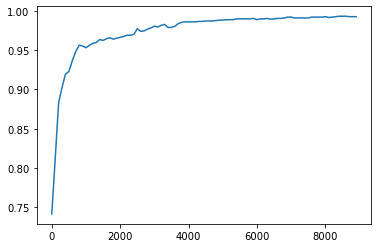

In [154]:
my_clf.plot_classifier_performance_vs_number_of_samples(test_rdm)

In [66]:
a = np.array([1,1,3])
b = a
a = np.vstack((a,b))
a = np.vstack((a,b))

In [67]:
a

array([[1, 1, 3],
       [1, 1, 3],
       [1, 1, 3]])

In [73]:
my_clf.w_hist.shape

(192080, 1)

In [90]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
np.vstack((a,b)).shape

(2, 3)

In [121]:
my_clf.w.value.shape

(784, 1)

In [125]:
np.reshape(my_clf.w_hist[:,0],[-1,1]).shape

(784, 1)

In [126]:
for it in range(0,my_clf.w_hist.shape[1]):
    print(it)

0
1
2
3
4
5
6
7
8


In [128]:
if np.array_equal(my_clf.w.value,np.reshape(my_clf.w_hist[:,8],[-1,1])):
    print("True")
else:
    print("False")

False


In [129]:
np.reshape(my_clf.w_hist[:,8],[-1,1])

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.0

In [130]:
my_clf.w.value

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.0